In [1]:
from dotenv import load_dotenv, find_dotenv
from langchain.schema.runnable import RunnableLambda
import re
import json
load_dotenv(find_dotenv())
import my_utils
from my_utils import extract_json_from_string
import os
my_utils.setupCuda()
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
def extract_json_from_string(text):
    # Xóa dấu phẩy cuối cùng trong JSON nếu có
    text = re.sub(r',\s*}', '}', text)
    text = re.sub(r',\s*\]', ']', text)

    # Lấy từ dấu "{" đầu tiên đến dấu "}" cuối cùng
    match = re.search(r'\{.*\}', text, re.DOTALL)
    if match:
        json_str = match.group(0).replace(".","")
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            print("Lỗi: Không thể parse JSON")
            print(f"json_str: {json_str}")
            return None
    return None

In [2]:
# cuda visible devices = 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# GRAPH new

### Function for graph

##### Model

In [2]:
from langchain_community.llms.vllm import VLLM
# from vllm import SamplingParams
import json
 
vllm_model = VLLM(
    model="/home/trung/RAG_ADVANCED/Qwen2.5-14B-Instruct-GPTQ-Int4",
    tensor_parallel_size=1,
    n=1,
    presence_penalty=0.0,
    frequency_penalty=0.0,
    temperature=0.0,
    top_p=1.0,
    top_k=-1,
    stop=None,
    ignore_eos=False,
    max_new_tokens= 512, # 2048
    logprobs=None,
    download_dir=None,
    vllm_kwargs={
        "quantization":"gptq",
        "max_model_len": 768,  #3036
        "gpu_memory_utilization":0.5
    }
)

/home/trung/.conda/envs/rag_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-26 09:26:31,890	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 02-26 09:26:32 __init__.py:207] Automatically detected platform cuda.
INFO 02-26 09:26:39 config.py:549] This model supports multiple tasks: {'embed', 'score', 'generate', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 02-26 09:26:39 gptq_marlin.py:147] Detected that the model can run with gptq_marlin, however you specified quantization=gptq explicitly, so forcing gptq. Use quantization=gptq_marlin for faster inference
WARNING 02-26 09:26:39 config.py:628] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 02-26 09:26:39 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/home/trung/RAG_ADVANCED/Qwen2.5-14B-Instruct-GPTQ-Int4', speculative_config=None, tokenizer='/home/trung/RAG_ADVANCED/Qwen2.5-14B-Instruct-GPTQ-Int4', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=768, d

OutOfMemoryError: CUDA out of memory. Tried to allocate 34.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 32.44 MiB is free. Process 1939 has 934.00 MiB memory in use. Process 76022 has 970.00 MiB memory in use. Process 76018 has 970.00 MiB memory in use. Process 506251 has 17.82 GiB memory in use. Including non-PyTorch memory, this process has 2.96 GiB memory in use. Of the allocated memory 2.50 GiB is allocated by PyTorch, and 22.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### routerQuery

In [ ]:
### Router
from langchain_core.prompts import PromptTemplate

# Prompt 
routerquery_template = """<|im_start|>system

You are an expert in routing user questions to the appropriate data source: either a vectorstore or web search.

Data Sources:
Vectorstore: Contains laws related to labor contracts, labor-related issues, and agreements between employers and employees.
Use this source for questions about employment contracts, worker rights, labor laws, employer-employee agreements, and related regulations.
Web Search: Use this for all other topics that are not covered by the vectorstore.

If the question is ambiguous or partially related to labor laws, prioritize vectorstore unless it explicitly requires external, real-time, or broader information.
Instructions:
Determine the appropriate data source based on the question's topic.
Return the result in the following JSON format:
{{
  "datasource": "vectorstore" | "web_search"
}}
<|im_end|>

<|im_start|>user
Question: {question}

<|im_end|>

<|im_start|>assistant
"""

routerquery_prompt = PromptTemplate.from_template(routerquery_template)

# Chain
question_router = routerquery_prompt | vllm_model |RunnableLambda(extract_json_from_string)

print(question_router.invoke({"question": "who is Biden"}))
print(question_router.invoke({"question": """第1章　総則
第1条（目的）
１．この就業規則（以下「規則」という。）は、株式会社●●●●の労働者の就業に関する事項を定めるものである。
"""}))

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, est. speed input: 805.24 toks/s, output: 55.21 toks/s]


{'datasource': 'web_search'}


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, est. speed input: 1072.42 toks/s, output: 56.44 toks/s]

{'datasource': 'vectorstore'}


#### propositions

In [ ]:
# proposition_template="""<|im_start|>system
# The following input is a legal document or contract. Your task is to break down the document into simple, self-contained propositions that are easy to understand. Follow these steps:

# 1.Identify key sentences: Read the entire document and identify sentences that contain factual information, rules, or conditions. Ignore introductory sentences, transitional sentences, or ambiguous statements (e.g., "The leave period is as follows." or "The contents of this contract are as follows.").

# 2.Make each proposition self-contained: Each proposition should be understandable on its own, without additional context. Replace pronouns and vague references with specific names or terms.

# 3.Ensure accuracy and completeness: Include necessary details such as dates, legal references, and conditions to ensure the propositions are accurate. Avoid incomplete or ambiguous propositions (e.g., "The company will respond appropriately." → "The company will provide appropriate compensation if an employee suffers a work-related accident.").

# 4.Maintain logical structure: Each proposition should be a complete sentence with a clear subject and predicate. If a rule contains multiple conditions, split them into separate propositions while maintaining logical relationships. Merge related propositions when necessary to preserve meaning.

# 5.Avoid overlapping propositions: Each proposition must convey distinct information and should not be a restatement of another proposition with minor modifications. Avoid cases where one proposition is a broader version of another with additional details. Instead, structure the propositions so that they remain independent while covering all necessary details.

# 6.Extract sub-clause number(s) if available:

# If a sub-clause number (e.g., ①, ②, (1), (2)) appears at the beginning of a sentence in the input document, extract it and associate it with the corresponding proposition.
# Convert numbered symbols to integers (e.g., ① → 1, (2) → 2).
# If multiple sub-clauses are combined into a single proposition, return them as an array (e.g., [1, 2]).
# If no sub-clause number is present, return an empty array [].
# Use appropriate legal or technical terms: Write all propositions in English and use proper legal or technical terminology.
# The response should be in Japanese and returned in following JSON format:
# {{
#   "propositions": 
#     [
#     {{"proposition":"Generated proposition 1",
#       "sub-clause": [int]
#     }},
#     {{"proposition":"Generated proposition 2",
#       "sub-clause": [int]
#     }}...
#     ]
# }}
# <|im_end|>

# <|im_start|>user
# contract:{document}
# <|im_end|>

# <|im_start|>assistant
# """
proposition_template="""<|im_start|>system
The following input is a legal document or contract. Your task is to break down the document into simple, self-contained propositions that are easy to understand. Follow these steps:

1. Identify key sentences: 
Read the entire document and extract factual information, rules, or conditions. Ignore introductory or transitional phrases that do not contain substantial content.

2. Ensure completeness of definitions:  
   - If a proposition defines a term (for example: "Xとは…"), ensure it contains a complete definition.  
   - Do not generate incomplete propositions such as:  
    "A worker is defined as follows." → This does not provide a definition.  
    Instead, include the full definition within the same proposition:  
    "A worker is a person who joins the company according to the procedure set forth in Chapter 2 and meets the following criteria: [list of criteria]."  

3. Make each proposition self-contained:  
   - Ensure the proposition is understandable without additional context.  
   - Replace pronouns or vague references with explicit terms.  

4. Maintain accuracy and include all necessary details:  
   - Retain legal references, dates, and conditions to avoid ambiguity.  
   - If a rule contains multiple conditions, split them into separate propositions while preserving logical relationships.  

5. Avoid overlapping or redundant propositions:  
   - Do not generate broad statements that are just incomplete versions of other propositions.  

6.Extract sub-clause number(s) if available:

If a sub-clause number (for example: ①, ②, (1), (2)) appears at the beginning of a sentence in the input document, extract it and associate it with the corresponding proposition.
Convert numbered symbols to integers (for example: ① → 1, (2) → 2).
If multiple sub-clauses are combined into a single proposition, return them as an array (for example: [1, 2]).
If no sub-clause number is present, return an empty array [].
Use appropriate legal or technical terms: Write all propositions in English and use proper legal or technical terminology.
7. Include extracted text from the original contract:  
   - For each generated proposition, provide the exact text from the input contract that was used to generate it.  
   - Ensure that the extracted text is accurate and directly supports the generated proposition.  

The response should be in Japanese and returned in following JSON format:
{{
  "propositions": 
    [
    {{"proposition":"Generated proposition in japanese",
      "sub-clause": [int],
      "extracted_text": "Extracted text from contract in japanese"
    }}
    ]
}}
<|im_end|>

<|im_start|>user
contract:{document}
<|im_end|>

<|im_start|>assistant
"""
proposition_prompt = PromptTemplate.from_template(proposition_template)
proposition_generator = proposition_prompt | vllm_model| RunnableLambda(extract_json_from_string)
# proposition_generator.invoke({"document":"""会社は、業務上必要がある場合に労働者に対し以下の人事異動を命ずることがある。
# (1)就業する場所及び従事する業務の変更
# (2)関連会社への出向
# (3)関連会社への転籍
# (4)会社は、第３条第２項に定めるところにより、従業員にその他の業務を行わせることができる。                             
# """})
# proposition_generator.invoke({"document":"""労働者として採用された者は、採用を通知された日から会社が指定する期日までに次の書類を提出しなければならない。ただし、会社が認めた場合には、その一部を省略または提出期限を延期することができる。
# 　⑫身元保証書
# 　⑬雇用保険被保険者証の写し
# 　⑭マイナンバーカード又はマイナンバー通知書の写し
# 　⑮資格免許証の写し
# 　⑯健康診断結果
# 　⑰学生証の写し
# 　⑱パスポートの写し
# 　⑲その他会社が必要と認めたもの
# """})
# proposition_generator.invoke({"document":"""労働者として採用された者は、採用を通知された日から会社が指定する期日までに次の書類を提出しなければならない。ただし、会社が認めた場合には、その一部を省略または提出期限を延期することができる。
# 　①履歴書・職務経歴書
# 　②入社誓約書
# 　③個人情報保護法に基づく誓約書
# 　④住民票記載事項証明書
# 　⑤給与所得者の扶養控除等（異動）申告書
# 　⑥源泉徴収票
# 　⑦雇用契約書
# 　⑧年金手帳の写し
# 　⑨通勤手当申請書
# 　⑩住宅手当申請書
# 　⑪給与振込先申請書
# 　⑫身元保証書
# 　⑬雇用保険被保険者証の写し
# 　⑭マイナンバーカード又はマイナンバー通知書の写し
# 　⑮資格免許証の写し
# 　⑯健康診断結果
# 　⑰学生証の写し
# 　⑱パスポートの写し
# 　⑲その他会社が必要と認めたもの
# """})


#### extract reference

In [ ]:
extract_reference_template="""<|im_start|>system
You will receive:

1. **A passage from a contract** that may include references to other sections, articles, clauses, or parts of the contract (e.g., “as specified in Section 2”, “according to the clause above”, “refer to Article 3 below”).
2. **Metadata** providing context for the current passage, including details such as the current Chapter, Article, and Clause.

### Task:

#### **Step 1: Extract References**
- Identify and extract all phrases in the contract text that refer to other sections, articles, or clauses.

#### **Step 2: Resolve References**
- Use the provided metadata to determine the specific Chapter, Article, or Clause that each reference points to.
- Examples:
  - If the metadata indicates that the current passage is in **Article 1**:
    - “the above article” refers to **Article 0** (or the last article of the previous section, if applicable).
    - “clause 3 below” refers to **Clause 3** in the subsequent article or section.
- If a reference **cannot be precisely resolved**, set its `"resolved"` value to -1.

The response should be in Japanese and returned in following JSON format:
{{
  "has_reference" : "yes" | "no",
  "is_extractable" : "yes" | "no"
  "references": [
    {{
      "text": str,
      "resolved": {{
        "Chapter": int| -1,
        "Article": int| -1,
        "clause": int| -1,
        "sub_clause": int|-1,
      }}
    }}
  ]
}}
"has_reference": "yes" if there is at least one reference, otherwise "no".
"is_extractable": "yes" if the reference can be extracted and resolved, otherwise "no".
"references": A list of extracted references, each containing:
"text": The extracted reference phrase.
"resolved": The resolved location, with -1 if it cannot be determined.

<|im_end|>

<|im_start|>user
contract:{document}
metadata:{metadata}
<|im_end|>

<|im_start|>assistant
"""
extract_reference_prompt = PromptTemplate.from_template(extract_reference_template)
extract_reference_generator = extract_reference_prompt | vllm_model| RunnableLambda(extract_json_from_string)
# document = """本契約の第2条に基づき、甲は乙に対し、必要な情報を提供しなければならない。また、第1章の規定に従い、支払いは第3条に定められた条件で行われる。
# """
# document="""本契約の第4条に基づき、甲は、上記2条に記載されている条件に従うものとする。"""
# document="""本契約の第4条第2項第3号に基づき、甲は、上記第2条第1項に記載されている条件に従うものとする。"""
document ="""会社は、対象者が正当な理由なく前項の診断書等の提出を拒んだ場合、休職を認めないことができる。"""
# metadata="""{
#   "current_chapter": 2,
#   "current_article": 3
# }"""
metadata="""{
  "current_chapter": 1,
  "current_article": 4,
  "current_clause": 4,
  "current_sub_clause": 5
}"""
extract_reference_generator.invoke({"document":document,"metadata":metadata})

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, est. speed input: 518.94 toks/s, output: 78.31 toks/s]


{'has_reference': 'yes',
 'is_extractable': 'yes',
 'references': [{'text': '前項',
   'resolved': {'Chapter': 1, 'Article': 4, 'clause': 3, 'sub_clause': -1}}]}

#### sematic reference

In [ ]:
# sematic_reference_template="""<|im_start|>system
# Determine whether the two clauses are directly related in a way that they require each other to be fully understood. If one clause cannot be fully understood without the other, or if they directly complement each other in meaning, return "yes". If each clause can exist independently without losing essential meaning, return "no".

# The response should be returned in following JSON format:
# {{
#   "analysis": "A brief explanation of why they are related or not."
#   "is_related": "yes"|"no",
# }}
# <|im_end|>

# <|im_start|>user
# Clause 1: {clause_1}
# Clause 2: {clause_2}
# <|im_end|>

# <|im_start|>assistant
# """
sematic_reference_template = """<|im_start|>system
Determine whether two clauses (Documents) are directly related based solely on whether Clause 1’s page_content explicitly references metadata details of Clause 2. Do not consider any references present in Clause 2’s page_content.

Each input is a Document with the following structure:
- metadata: a dictionary containing:
    - article_number: The identifier of the chapter.
    - article_title: The content of the chapter.
    - chapter_number: The identifier of the article (within the chapter).
    - chapter_title: The content of the article.
    - clause_number: The identifier of the clause (within the article).
    - clause_title: The content of the clause.
    - sub_clause_number: The identifier of the sub-clause (if any, within the clause).
    - sub_clause_content: The content of the sub-clause (if any).
- page_content: The full text content of the clause.

Return "yes" if and only if Clause 1’s page_content explicitly mentions any metadata detail (e.g., clause number, clause title, or other specific identifiers) that uniquely corresponds to Clause 2. Otherwise, return "no". Do not use any information from Clause 2’s page_content when making your determination.

For example:

Case 1 (Should be "no"):
Clause 1:
Document(metadata={{'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}}, page_content='パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。')

Clause 2:
Document(metadata={{'article_number': '49', 'article_title': '契約更新の上限年齢および定年', 'chapter_number': '7', 'chapter_title': '定年、退職及び解雇', 'clause_number': '3', 'clause_title': '第1項および第2項第1号の定年で退職したパートタイム及びアルバイトが希望するときは、改めて有期労働契約を締結し、最長65歳に達するまで引き続き雇用する。ただし、', 'sub_clause_content': '', 'sub_clause_number': ''}}, page_content='...')

In this case, Clause 1’s page_content does not reference any metadata details of Clause 2; therefore, the output must be "no".

Case 2 (Should be "yes"):
Clause 1:
Document(metadata={{'article_number': '49', 'article_title': '契約更新の上限年齢および定年', 'chapter_number': '7', 'chapter_title': '定年、退職及び解雇', 'clause_number': '3', 'clause_title': '第1項および第2項第1号の定年で退職したパートタイム及びアルバイトが希望するときは、改めて有期労働契約を締結し、最長65歳に達するまで引き続き雇用する。ただし、', 'sub_clause_content': '', 'sub_clause_number': ''}}, page_content='...第1項...')

Clause 2:
Document(metadata={{'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}}, page_content='...')

In this case, Clause 1’s page_content explicitly mentions an identifier (e.g., "第1項") that matches Clause 2’s metadata (clause_number '1'). Therefore, the output must be "yes".

Provide your answer in the following JSON format:
{{
    "analysis": "A brief explanation of why the two clauses are related or not.", 
    "is_related": "yes"|"no"
}}
<|im_end|>

<|im_start|>user
Clause 1: {clause_1}
Clause 2: {clause_2}
<|im_end|>
"""



sematic_reference_prompt = PromptTemplate.from_template(sematic_reference_template)
sematic_reference_generator = sematic_reference_prompt | vllm_model| RunnableLambda(extract_json_from_string)

clause_1 ="""Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '退職', 'article_number': '50', 'clause_number': '1', 'clause_title': '第49条に定めるもののほか、労働者が次のいずれかに該当するときは、退職とす る。', 'sub_clause_number': '1', 'sub_clause_content': '退職を願い出て会社が承認したとき'}, page_content='第49条に定めるもののほか、労働者が次のいずれかに該当するときは、退職とす る。\n退職を願い出て会社が承認したとき')"""
clause_2 ="""Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。')"""

sematic_reference_generator.invoke({"clause_1":clause_1,"clause_2":clause_2})

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 02-26 09:18:21 scheduler.py:1091] Input prompt (1316 tokens) is too long and exceeds limit of 1024


Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 692.02it/s, est. speed input: 971095.01 toks/s, output: 0.00 toks/s]


In [ ]:
# sematic_reference_template="""<|im_start|>system
# Determine whether the two clauses are directly related in a way that they require each other to be fully understood. If one clause cannot be fully understood without the other, or if they directly complement each other in meaning, return "yes". If each clause can exist independently without losing essential meaning, return "no".

# The response should be returned in following JSON format:
# {{
#   "analysis": "A brief explanation of why they are related or not."
#   "is_related": "yes"|"no",
# }}
# <|im_end|>

# <|im_start|>user
# Clause 1: {clause_1}
# Clause 2: {clause_2}
# <|im_end|>

# <|im_start|>assistant
# """

sematic_reference_template = """<|im_start|>system
Determine whether two clauses (Documents) are directly related based solely on the following rules:
- If Clause 1’s page_content explicitly references a legal provision identifier (such as the article number, clause number, clause title, or provision title) that appears in Clause 2’s metadata, then return "yes".
- If Clause 1’s page_content only references chapter-level information (for example, the chapter number or chapter title) from Clause 2’s metadata without specific legal provision details, then evaluate whether the content of Clause 2 is directly relevant to or supplements the issue raised by Clause 1; if it does, return "yes", otherwise return "no".
- If Clause 1 does not reference either legal provision identifiers or chapter-level identifiers of Clause 2, return "no".

Each input is a Document with the following structure:
- metadata: a dictionary containing:
    - chapter_number: The identifier of the chapter.
    - chapter_title: The title of the chapter.
    - article_number: The identifier of the article.
    - article_title: The title of the article.
    - clause_number: The identifier of the clause.
    - clause_title: The title of the clause.
    - sub_clause_number: The identifier of the sub-clause (if any).
    - sub_clause_content: The content of the sub-clause (if any).
- page_content: The full text content of the clause.

Provide your answer in the following JSON format:
{{"analysis": "A brief explanation of why the two clauses are related or not.", "is_related": "yes"|"no"}}
<|im_end|>

<|im_start|>user
Clause 1: {clause_1}
Clause 2: {clause_2}
<|im_end|>
<|im_start|>assistant
"""



sematic_reference_prompt = PromptTemplate.from_template(sematic_reference_template)
sematic_reference_generator = sematic_reference_prompt | vllm_model| RunnableLambda(extract_json_from_string)

clause_1 ="""Document(metadata={'article_title': '労働者の定義及び適用範囲', 'article_number': '2', 'chapter_title': '総則', 'chapter_number': '1', 'clause_number': '2'}, page_content='この規則で労働者とは第2章に定める手続きにより入社した者で、次の通り定義する。\n① 正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働 者で期間の定めがなく雇用される基幹業務に従事する労働者 ② 勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と 比べ限定され雇用される労働者 ③ 職務限定社員・・・・契約社員・アルバイト以外の労働者で期間の定めがなく職務が正社員と比 べ限定され雇用される労働者 ④ 短時間正社員・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働 者で期間の定めがなくフルタイム勤務で働く正社員に比べ短い労働時間で 雇用される労働者 ')"""
clause_2 ="""Document(metadata={'chapter_title': '採用、異動等', 'chapter_number': '2', 'article_title': '採用時の提出書類', 'article_number': '6', 'clause_number': '1', 'clause_title': '労働者として採用された者は、採用を通知された日から会社が指定する期日までに次の書類を提出しなければならない。ただし、会社が認めた場合には、その一部を省略または提出期限を延期することができる。', 'sub_clause_number': '1', 'sub_clause_content': '履歴書・職務経歴書'}, page_content='労働者として採用された者は、採用を通知された日から会社が指定する期日までに次の書類を提出しなければならない。ただし、会社が認めた場合には、その一部を省略または提出期限を延期することができる。\n履歴書・職務経歴書')"""


sematic_reference_generator.invoke({"clause_1":clause_1,"clause_2":clause_2})

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it, est. speed input: 660.84 toks/s, output: 78.81 toks/s]


{'analysis': "Clause 1's page_content does not explicitly reference any legal provision identifier from Clause 2's metadata Clause 1 defines different types of workers, while Clause 2 specifies the documents that must be submitted by workers upon hiring Although both clauses are related to workers, Clause 2 does not directly supplement the issue raised by Clause 1 Clause 2 is under a different chapter and does not provide additional details on the definitions given in Clause 1",
 'is_related': 'no'}

#### generation

In [ ]:


# Prompt

# template="""<|im_start|>system
# You are a legal analysis AI specializing in contract evaluation. Your task is to analyze a given contract segment and determine whether it violates, complies with, or lacks sufficient information to conclude compliance or violation based on the provided laws.
# Inputs are Laws and Contract Segment.
# Laws: A set of legal provisions relevant to the contract.
# Contract Segment: A specific portion of a contract that needs evaluation.

# Evaluation Criteria:
# Compliance: The contract fully adheres to the relevant legal provisions.
# Violation: The contract contradicts or does not meet the requirements of the legal provisions.
# Insufficient Information: The given contract segment does not provide enough details to determine compliance or violation.
# The response should be in Japanese and returned in following JSON format:
# {{
#   "evaluation": "compliance" | "violation" | "insufficient_information",
#   "explanation": "A brief but clear explanation of why the contract complies, violates, or lacks sufficient information.",
#   "legal_references": [
#     {{
#       "law": "The specific law that was referenced",
#       "relevance": "Explanation of how this law applies to the contract"
#     }}
#   ],
#   "suggested_corrections": "Suggested modifications (if necessary) to ensure compliance."
# }}
# <|im_end|>

# <|im_start|>user
# Laws: [{context}].
# Contract Segment: [{contract}]

# <|im_end|>

# <|im_start|>assistant
# """

template="""<|im_start|>system
You are a legal analysis AI specializing in contract evaluation. Your task is to analyze a given contract segment and determine whether it violates, complies with, or lacks sufficient information to conclude compliance or violation based on the provided laws.
Inputs are Laws and Contract Segment.
Laws: A set of legal provisions relevant to the contract.
Contract Segment: A specific portion of a contract that needs evaluation.

Evaluation Criteria:
Compliance: The contract fully adheres to the relevant legal provisions.
Violation: The contract contradicts or does not meet the requirements of the legal provisions.
Insufficient Information: The given contract segment does not provide enough details to determine compliance or violation.
The response should be in Japanese and returned in following JSON format:
{{
  "evaluation": "compliance" | "violation" | "insufficient_information",
  "explanation": "A brief but clear explanation of why the contract complies, violates, or lacks sufficient information.",
}}
<|im_end|>

<|im_start|>user
Laws: [{context}].
Contract Segment: [{contract}]

<|im_end|>

<|im_start|>assistant
"""

prompt = PromptTemplate.from_template(template)

# Chain
rag_chain = prompt | vllm_model | RunnableLambda(extract_json_from_string)


contract="""第5条（労働時間および休憩時間）

従業員の労働時間は、1日8時間、週40時間を超えないものとする。"""
context="""労働基準法 (労基法) 第32条 - 労働時間の制限
使用者は、労働者に対し、1週間について40時間を超えて労働させてはならない。
使用者は、労働者に対し、1日について8時間を超えて労働させてはならない。
労働基準法 (労基法) 第34条 - 休憩時間
使用者は、労働時間が6時間を超える場合は少なくとも45分、8時間を超える場合は少なくとも1時間の休憩時間を労働者に与えなければならない。
休憩時間は、労働時間の途中に与えなければならず、自由に利用させなければならない。"""
# Run
generation = rag_chain.invoke({"context": context, "contract": contract})
print(generation)
# print(prompt)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, est. speed input: 232.94 toks/s, output: 83.67 toks/s]

{'evaluation': 'compliance', 'explanation': '契約条項は、労働基準法第32条に従い、1日8時間、週40時間以内の労働時間を定めています。ただし、労働基準法第34条に基づく休憩時間の規定については、契約条項に言及されていません。従って、労働時間が6時間以上8時間未満の場合の休憩時間の規定が不明であり、この点については不足しています。しかし、労働時間の制限については法に従っているため、全体としては法に準拠しています。'}


#### retrieval grader

In [ ]:
### Retrieval Grader 

retrieval_grader_template="""<|im_start|>system
You are an evaluator assessing the relevance of a retrieved law to a given contract segment.
Evaluation Criteria:
Answer "yes" only if the retrieved law can be used as direct evidence to determine whether the contract segment complies with the law or violates the law.
In all other cases, including where the law is not directly applicable or does not provide clear evidence of compliance or non-compliance, answer "no".
The law must have a direct and actionable link to the contract segment's compliance or violation of legal standards.

Your response should focus on whether the law can serve as direct evidence of the contract’s legal compliance or non-compliance.

Provide a binary score to indicate relevance:
"yes": The law provides direct evidence of the contract segment’s compliance or violation of the law.
"no": The law does not provide direct evidence regarding compliance or violation.

The response should be returned in following JSON format:
{{
  "analysis": "your analysis steps, must not generate '"' in here",
  "binary_score": "yes" |"no"
}}
<|im_end|>

<|im_start|>user
Law: [{context}].
Contract Segment: [{contract}]

<|im_end|>

<|im_start|>assistant
"""

retrieval_grader_prompt = PromptTemplate.from_template(retrieval_grader_template)

# Chain
retrieval_grader = retrieval_grader_prompt | vllm_model |RunnableLambda(extract_json_from_string)


# generation = retrieval_grader.invoke({"context": """この法律で「労働者」とは、職業の種類を問わず、事業又は事務所（以下「事業」という。）に使用される者で、賃金を支払われる者をいう。
# """, "contract": """**労働者の定義**

# 本契約において、「労働者」とは、第2章に規定する手続きに従って入社した者であり、特定の定義に基づいて分類される者を指します。"""})
generation = retrieval_grader.batch([{"context": """この法律で「労働者」とは、職業の種類を問わず、事業又は事務所（以下「事業」という。）に使用される者で、賃金を支払われる者をいう。
""", "contract": """**労働者の定義**

本契約において、「労働者」とは、第2章に規定する手続きに従って入社した者であり、特定の定義に基づいて分類される者を指します。"""}]*50)

print(generation)
# print(prompt)


Processed prompts:   0%|          | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 02-26 09:18:25 scheduler.py:1754] Sequence group 23 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s, est. speed input: 1305.16 toks/s, output: 529.12 toks/s]

[{'analysis': "The provided law defines '労働者' as someone who is employed in a business or office and receives wages, regardless of the type of work The contract segment, however, defines '労働者' based on the procedures outlined in Chapter 2 and a specific classification system The contract segment does not align with the legal definition provided in the law, but the law does not directly address the compliance of the contract segment's specific classification system Therefore, the law does not provide direct evidence of compliance or violation of the contract segment's definition of '労働者'", 'binary_score': 'no'}, {'analysis': "The provided law defines '労働者' as someone who is employed in a business or office and receives wages, regardless of the type of work The contract segment, however, defines '労働者' based on the procedures outlined in Chapter 2 and a specific classification system The contract segment does not align with the legal definition provided in the law, but the law does not di

In [ ]:
generation

[{'analysis': "The provided law defines '労働者' as someone who is employed in a business or office and receives wages, regardless of the type of work The contract segment, however, defines '労働者' based on the procedures outlined in Chapter 2 and a specific classification system The contract segment does not align with the legal definition provided in the law, but the law does not directly address the compliance of the contract segment's specific classification system Therefore, the law does not provide direct evidence of compliance or violation of the contract segment's definition of '労働者'",
  'binary_score': 'no'},
 {'analysis': "The provided law defines '労働者' as someone who is employed in a business or office and receives wages, regardless of the type of work The contract segment, however, defines '労働者' based on the procedures outlined in Chapter 2 and a specific classification system The contract segment does not align with the legal definition provided in the law, but the law does not

#### hallucination grader

In [ ]:
### Retrieval Grader 

hallucination_grader_template="""<|im_start|>system
The input consists of laws and a generated explanation.
Your task is to determine whether the generated explanation is supported by the information in the laws.

### Evaluation criteria:
- If the explanation is directly supported by the laws, return "no".
- If the explanation is not supported by the laws, return "yes".

The response must be returned in the following JSON format:
{{
  "is_supported": "yes" or "no",
}}
<|im_end|>

<|im_start|>user
laws: [{laws}]  
generated explanation: [{explanation}]  
<|im_end|> 
<|im_start|>assistant
"""

hallucination_grader_prompt = PromptTemplate.from_template(hallucination_grader_template)

# Chain
hallucination_grader = hallucination_grader_prompt | vllm_model|RunnableLambda(extract_json_from_string)

explanation = """本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。"""

generation = hallucination_grader.invoke({"laws": """昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十条\u3000解雇の予告/使用者は、労働者を解雇しようとする場合においては、少くとも三十日前にその予告をしなければならない。三十日前に予告をしない使用者は、三十日分以上の平均賃金を支払わなければならない。但し、天災事変その他やむを得ない事由のために事業の継続が不可能となつた場合又は労働者の責に帰すべき事由に基いて解雇する場合においては、この限りでない。\n前項の予告の日数は、一日について平均賃金を支払つた場合においては、その日数を短縮することができる。\n前条第二項の規定は、第一項但書の場合にこれを準用する。""", "explanation": explanation})
print(generation)
# print(prompt)


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, est. speed input: 418.12 toks/s, output: 80.28 toks/s]

{'is_supported': 'yes'}


#### answer grader

In [ ]:

# answer_grader_template="""<|im_start|>system
# The input consists of laws and a generated explanation.
# Your task is to determine whether the generated explanation is supported by the information in the laws.

# ### Evaluation criteria:
# - If the explanation is directly supported by the laws, return "no".
# - If the explanation is not supported by the laws, return "yes".

# The response must be returned in the following JSON format:
# {{
#   "is_supported": "yes" or "no",
# }}
# <|im_end|>

# <|im_start|>user
# laws: [{laws}]  
# generated explanation: [{explanation}]  
# <|im_end|> 
# <|im_start|>assistant
# """

# answer_grader_prompt = PromptTemplate.from_template(answer_grader_template)

# # Chain
# answer_grader = answer_grader_prompt | vllm_model

# explanation = """契約条項は、労働基準法第32条に従い、1日8時間、週40時間以内の労働時間を定めています。ただし、労働基準法第34条に基づく休憩時間の規定については、契約条項に言及されていません。従って、労働時間が6時間以上8時間未満の場合の休憩時間の規定が不明であり、この点については不足しています。しかし、労働時間の制限については法に従っているため、全体としては法に準拠しています。"""

# generation = hallucination_grader.invoke({"laws": context, "explanation": explanation})
# print(generation)
# # print(prompt)


#### query transformation

In [ ]:
# kết hợp paraphrase + Granularity Adjustment + query expansion
query_transformation_template="""<|im_start|>system
You are a natural language processing expert. Your task is to transform the input query into different variations based on the following criteria:  
### Instructions:  
1. **Paraphrasing (2 variations):** Rewrite the query in a different way while keeping the meaning unchanged.  
2. **Granularity Adjustment - More Detailed (2 variations):** Rewrite the query with a higher level of detail by adding specific elements without changing its meaning.  
3. **Granularity Adjustment - Less Detailed (2 variations):** Rewrite the query in a more generalized way by removing details while maintaining the overall meaning.  
4. **Query Expansion (2 variations):** Expand the query by adding relevant information to make it more comprehensive.  

The response must be returned in the following JSON format:
{{
  "paraphrased_queries": [
    "Paraphrased query 1",
    "Paraphrased query 2"
  ],
  "detailed_queries": [
    "More detailed query 1",
    "More detailed query 2"
  ],
  "generalized_queries": [
    "More generalized query 1",
    "More generalized query 2"
  ],
  "expanded_queries": [
    "Expanded query 1",
    "Expanded query 2"
  ]
}}
<|im_end|>

<|im_start|>user
Input Query:{query}  
<|im_end|> 
<|im_start|>assistant
"""

query_transformation_prompt = PromptTemplate.from_template(query_transformation_template)

# Chain
query_transformation_generator = query_transformation_prompt | vllm_model|RunnableLambda(extract_json_from_string)


generation = query_transformation_generator.invoke({"query": "勤務地限定社員とは契約社員、アルバイト以外の労働者で期間の定めがなく勤務地が正社員と比べて限定され雇用される労働者を指す。"})
print(generation)
# print(prompt)


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it, est. speed input: 46.81 toks/s, output: 87.90 toks/s]

{'paraphrased_queries': ['勤務地限定社員とは、契約社員やアルバイトを除く、期間の定めのない労働者で、勤務地が正社員よりも制限されている労働者を指す。', '期間の定めがなく、勤務地が制限されている労働者を指す用語で、契約社員やアルバイトを除く労働者を意味し、正社員と比較して勤務地が限定されている。'], 'detailed_queries': ['勤務地限定社員とは、契約社員やアルバイトを除く、期間の定めのない労働者で、特定の地域や施設に限定された勤務地で働く労働者を指し、その勤務地は正社員の勤務地と比べて制限されている。', '期間の定めがなく、特定の地域や施設に限定された勤務地で働く労働者を指す用語で、契約社員やアルバイトを除く労働者を意味し、その勤務地は正社員の勤務地と比べて制限されている。'], 'generalized_queries': ['勤務地限定社員とは、特定の地域や施設に限定された勤務地で働く労働者を指す。', '期間の定めがなく、特定の地域や施設に限定された勤務地で働く労働者を指す用語で、契約社員やアルバイトを除く労働者を意味する。'], 'expanded_queries': ['勤務地限定社員とは、契約社員やアルバイトを除く、期間の定めのない労働者で、特定の地域や施設に限定された勤務地で働く労働者を指し、その勤務地は正社員の勤務地と比べて制限されている。また、この用語は、労働者の雇用条件を特定の地域や施設に限定することで、労働者の移動性を制限する雇用形態を指す。', '期間の定めがなく、特定の地域や施設に限定された勤務地で働く労働者を指す用語で、契約社員やアルバイトを除く労働者を意味し、その勤務地は正社員の勤務地と比べて制限されている。この用語は、労働者の雇用条件を特定の地域や施設に限定することで、労働者の移動性を制限する雇用形態を指す。']}


#### question re-writer

In [ ]:

question_re_writer_template="""<|im_start|>system
You are an expert in query rewriting for improving information retrieval. Your task is to rewrite the given user query to make it more effective for retrieving relevant documents from a vectorstore or search engine.

Guidelines:
Clarify vague terms: If the original query is too broad or ambiguous, make it more specific.
Expand missing context: If the query lacks key details, infer and add relevant information based on intent.
Use precise terminology: Replace general words with domain-specific terms when applicable.
Avoid over-restricting: Ensure the rewritten query does not remove useful flexibility in retrieval.

The response must be returned in the following JSON format:
{{
"rewritten_query": str
}}


<|im_end|>

<|im_start|>user
"original_query": {original_query},
<|im_end|> 
<|im_start|>assistant
"""

question_re_writer_prompt = PromptTemplate.from_template(question_re_writer_template)

# Chain
question_rewriter = question_re_writer_prompt | vllm_model|RunnableLambda(extract_json_from_string)
retrieved_results=[]
generation = question_rewriter.invoke({"original_query": contract, "retrieved_results": json.dumps(retrieved_results)})
print(generation)
# print(prompt)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, est. speed input: 291.93 toks/s, output: 78.77 toks/s]

{'rewritten_query': 'Article 5 (Working Hours and Rest Breaks): Employee working hours should not exceed 8 hours per day or 40 hours per week Regulations regarding working hours and rest breaks under Article 5'}


In [ ]:
contract

'第5条（労働時間および休憩時間）\n\n従業員の労働時間は、1日8時間、週40時間を超えないものとする。'

#### Web Search Tool

In [ ]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

#### indexing

###### chroma

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
# # Load lại Embedding function
# embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

# # Load Vector Store từ thư mục đã lưu
# vector_store = Chroma(persist_directory="vectorDB", embedding_function=embedding_function)
# retriever = vector_store.as_retriever(search_kwargs={"k": 10})


In [ ]:
### init

import json
import json
import hashlib
from langchain.text_splitter import RecursiveCharacterTextSplitter

with open("/home/trung/RAG_ADVANCED/full_corpus_110225_with_metadata.json", "r", encoding="utf-8") as f:
    data_docs = json.load(f)

from langchain_core.documents import Document

docs = []
for doc in data_docs:
    docs.append(
        Document(
            page_content=doc["content"],
            metadata=doc["metadata"]
        )
    )

unique_documents = []
seen = set()

for document in docs:
    # Truy cập metadata và content từ đối tượng Document
    metadata = document.metadata
    content = document.page_content
    
    # Chuyển đổi metadata và content thành chuỗi JSON để so sánh
    doc_str = json.dumps({"metadata": metadata, "content": content}, sort_keys=True)
    
    # Tạo một hash MD5 cho chuỗi JSON này
    doc_hash = hashlib.md5(doc_str.encode('utf-8')).hexdigest()
    
    # Nếu tài liệu chưa gặp, thêm vào list unique_documents
    if doc_hash not in seen:
        unique_documents.append(document)
        seen.add(doc_hash)

# Kết quả là danh sách không có phần tử lặp
print("len unique_documents",len(unique_documents))
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
chunks = text_splitter.split_documents(unique_documents)
embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

vector_store = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_function,
    persist_directory="vectorDB")# lưu ý cái này sẽ lưu đè

retriever = vector_store.as_retriever(search_kwargs={"k": 10})

len unique_documents 4609


/tmp/ipykernel_524370/3357282127.py:45: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")


In [ ]:
# Load Vector Store từ thư mục đã lưu
trung = Chroma(persist_directory="vectorDB", embedding_function=embedding_function)
retriever = trung.as_retriever(search_kwargs={"k": 10})
num_documents = len(trung)

docs = retriever.get_relevant_documents("""第２章　採用、異動等
第６条（採用時の提出書類）
　４）採用内定後に犯罪行為等社会的に不名誉な行為を行ったとき、または採用選考時に過去の犯罪行
為等を秘匿していたことが判明したとき""")
print(num_documents)
docs

31060


/tmp/ipykernel_524370/4138845620.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  trung = Chroma(persist_directory="vectorDB", embedding_function=embedding_function)
/tmp/ipykernel_524370/4138845620.py:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("""第２章　採用、異動等


[Document(metadata={'article_name': '登録拒否事由', 'article_number': '第十四条の七', 'chapter_name': '登録', 'chapter_number': '第二章の二', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/343AC1000000089', 'enactment_year': '令和5年6月14日 施行', 'law_name': '社会保険労務士法', 'law_number': '昭和四十三年法律第八十九号'}, page_content='五\u3000社会保険労務士の信用又は品位を害するおそれがある者その他社会保険労務士の職責に照らし社会保険労務士としての適格性を欠く者'),
 Document(metadata={'article_name': '登録拒否事由', 'article_number': '第十四条の七', 'chapter_name': '登録', 'chapter_number': '第二章の二', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/343AC1000000089', 'enactment_year': '令和5年6月14日 施行', 'law_name': '社会保険労務士法', 'law_number': '昭和四十三年法律第八十九号'}, page_content='五\u3000社会保険労務士の信用又は品位を害するおそれがある者その他社会保険労務士の職責に照らし社会保険労務士としての適格性を欠く者'),
 Document(metadata={'article_name': '登録拒否事由', 'article_number': '第十四条の七', 'chapter_name': '登録', 'chapter_number': '第二章の二', 'division_name': '', 'division_number': '', 'document_sourc

###### dense retrieval

In [ ]:
# ### init

# import json
# import json
# import hashlib
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# with open("/home/thanhnguyen/Data/code/RAG_techniques/Phuc/full_corpus_110225_with_metadata.json", "r", encoding="utf-8") as f:
#     data_docs = json.load(f)

# from langchain_core.documents import Document

# docs = []
# for doc in data_docs:
#     docs.append(
#         Document(
#             page_content=doc["content"],
#             metadata=doc["metadata"]
#         )
#     )

# unique_documents = []
# seen = set()

# for document in docs:
#     # Truy cập metadata và content từ đối tượng Document
#     metadata = document.metadata
#     content = document.page_content
    
#     # Chuyển đổi metadata và content thành chuỗi JSON để so sánh
#     doc_str = json.dumps({"metadata": metadata, "content": content}, sort_keys=True)
    
#     # Tạo một hash MD5 cho chuỗi JSON này
#     doc_hash = hashlib.md5(doc_str.encode('utf-8')).hexdigest()
    
#     # Nếu tài liệu chưa gặp, thêm vào list unique_documents
#     if doc_hash not in seen:
#         unique_documents.append(document)
#         seen.add(doc_hash)

# # Kết quả là danh sách không có phần tử lặp
# print("len unique_documents",len(unique_documents))
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
# chunks = text_splitter.split_documents(unique_documents)
# embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")



In [ ]:
# ### using dense retrieval
# import numpy as np
# import json
# import torch
# import pickle
# from sentence_transformers import SentenceTransformer, util


# class RetrievalData:
#     def __init__(self, legal_dict_json, model_paths, legal_data_path, weighted, top_n=20, range_score=0.2, encode_legal_data_flag=False):
#         self.legal_dict_json = legal_dict_json
#         self.legal_data_path = legal_data_path
#         self.weighted = weighted
#         self.top_n = top_n
#         self.range_score = range_score
#         self.models = self.load_models(model_paths)

#         if encode_legal_data_flag:
#             self.emb_legal_data = self.encode_legal_data()
#             with open(self.legal_data_path, "wb") as f:
#                 pickle.dump(self.emb_legal_data, f)
#         else:
#             with open(self.legal_data_path, "rb") as f:
#                 self.emb_legal_data = pickle.load(f)

#     def load_models(self, model_paths):
#         return [SentenceTransformer(model_path) for model_path in model_paths]

#     def encode_legal_data(self):
#         doc_data = json.load(open(self.legal_dict_json, encoding='utf-8'))
#         list_emb_models = []
#         for model in self.models:
#             emb2_list = [model.encode(doc["content"]) for doc in doc_data]
#             list_emb_models.append(np.array(emb2_list))
#         return list_emb_models

#     def encode_question(self, question_data):
#         return [model.encode(question_data) for model in self.models]

#     def calculate_cosine_similarity(self, question_embs, list_embed=None):
#         cos_sim = []
#         if list_embed is not None:
#             print("vao no embed")
#             for idx, emb_legal in enumerate(list_embed):
#                 scores = util.cos_sim(torch.tensor(question_embs[idx]), torch.tensor(emb_legal))
#                 cos_sim.append(self.weighted[idx] * scores)
#         else:
#             print("vao yes embed")
#             for idx, emb_legal in enumerate(self.emb_legal_data):
#                 scores = util.cos_sim(torch.tensor(question_embs[idx]), torch.tensor(emb_legal))
#                 cos_sim.append(self.weighted[idx] * scores)
#         cos_sim = torch.cat(cos_sim, dim=0)
#         # Dùng flatten() thay vì squeeze(0) để đảm bảo kết quả là 1-d array.
#         cos_sim = torch.sum(cos_sim, dim=0).flatten().numpy()
#         return cos_sim

#     def process_predictions(self, cos_sim):
#         # Đảm bảo cos_sim có dạng ít nhất là 1-d array
#         cos_sim = np.atleast_1d(cos_sim)
#         max_score = np.max(cos_sim)
#         # Sử dụng số lượng phần tử tối đa là min(top_n, len(cos_sim))
#         k = min(self.top_n, len(cos_sim))
#         predictions = np.argpartition(cos_sim, len(cos_sim) - k)[-k:]
#         new_scores = cos_sim[predictions]
#         new_predictions = np.where(new_scores >= (max_score - self.range_score))[0]
#         map_ids = predictions[new_predictions]
#         new_scores = new_scores[new_scores >= (max_score - self.range_score)]
#         if new_scores.shape[0] > k:
#             predictions_2 = np.argpartition(new_scores, len(new_scores) - k)[-k:]
#             map_ids = map_ids[predictions_2]
#         return map_ids, new_scores

#     def display_results(self, map_ids):
#         dup_ans = []
#         with open(self.legal_dict_json, 'r', encoding='utf-8') as file:
#             doc_data = json.load(file)
#         for idx_pred in map_ids:
#             law_id_article = doc_data[idx_pred]["id"]
#             content = doc_data[idx_pred]["content"]
#             if law_id_article not in dup_ans:
#                 dup_ans.append(law_id_article)
#                 print(f'Law and Article ID: {law_id_article}')
#                 print(f'Text: {content}')
#                 print("=" * 80)

#     def inference(self, question, list_embed=None):
#         question_embs = self.encode_question(question)
#         cos_sim = self.calculate_cosine_similarity(question_embs, list_embed)
#         map_ids, new_scores = self.process_predictions(cos_sim)
#         return map_ids[:5], new_scores[:5]
#         # self.display_results(map_ids)



# if __name__ == "__main__":
#     model_paths = ["/home/hoangphuc/Nhap/RAG_Pb/saved_model_finetune_mlm_lms_round2"]
#     legal_dict_json = "/home/hoangphuc/Nhap/RAG_Pb/generated_data/full_corpus_110225_with_metadata_new.json"
#     legal_data_path = "/home/hoangphuc/Nhap/RAG_Pb/generated_data/vectorDB_full_corpus_110225.pkl"
#     # weighted = [0.3, 0.2, 0.5]
#     weighted = [1.0]

#     retrieval = RetrievalData(legal_dict_json, model_paths, legal_data_path, weighted, encode_legal_data_flag = True)

In [ ]:
# def display_results(map_ids, new_scores):
#     dup_ans = []
#     with open(legal_dict_json, 'r', encoding='utf-8') as file:
#         doc_data = json.load(file)
#     for idx_pred in map_ids:
#         law_id_article = doc_data[idx_pred]["id"]
#         content = doc_data[idx_pred]["content"]
#         if law_id_article not in dup_ans:
#             dup_ans.append(law_id_article)
#             print(f'Law and Article ID: {law_id_article}')
#             print(f'Text: {content}')
#             print("=" * 80)
# def return_documents(map_ids, new_scores):
#     dup_ans = []
#     with open(legal_dict_json, 'r', encoding='utf-8') as file:
#         doc_data = json.load(file)
#     test_docs = []
#     for idx_pred in map_ids:
#         law_id_article = doc_data[idx_pred]["id"]
#         content = doc_data[idx_pred]["content"]
#         metadata = doc_data[idx_pred]["metadata"]

#         if law_id_article not in dup_ans:
#             test_docs.append(
#                 Document(
#                     page_content=content,
#                     metadata=metadata
#                 )
#             )
#             dup_ans.append(law_id_article)
#     return test_docs  

In [ ]:
# # question = input("\nEnter a contract sentence: ").strip()
# question = "雇用主が従業員を解雇する場合、雇用契約で定められている通知期間は、40日以上である必要があるのか？"
# map_ids, new_scores = retrieval.inference(question)
# documents = return_documents(map_ids, new_scores)
# # display_results(map_ids, new_scores)

In [ ]:
# documents

### Graph state

In [26]:
from typing_extensions import TypedDict
from typing import List
# from langchain.schema import Document
from langchain_core.documents import Document

class Proposition(TypedDict):
    proposition_content: Document # sửa khi trích metadata
    documents: List[Document]  # Sử dụng Document thay vì List[str]
    filtered_documents: List[Document]
    # direct_reference:List[Document]
    # sematic_reference:List[Document]
    # generation: str

class Question(TypedDict):
    question_content: Document
    propositions: List[Proposition]
    ref_propositions: List[Proposition]
    direct_reference:List[Document]
    sematic_reference:List[Document]
    generation: str
    

class propositions_to_rewrite(TypedDict):
    question_index: int
    proposition_index: int
    original_proposition: Proposition


class GraphState(TypedDict):
    questions: List[Question]  # Lưu danh sách các câu hỏi thay vì chỉ một câu hỏi
    propositions_to_rewrite : List[propositions_to_rewrite]
    rewrite_count :int

### Graph Flow

## Cur

In [27]:
from pathlib import Path
import shutil

def create_or_update_index(collection_name: str, embedding_model, persist_directory: str, 
                           all_docs: List[Document], clear_persist_folder: bool = False):
    """
    Tạo hoặc cập nhật index vector.
    - Nếu `clear_persist_folder=True`, sẽ xóa thư mục lưu trữ trước khi tạo lại từ đầu.
    - Nếu `clear_persist_folder=False`, sẽ giữ dữ liệu cũ và chỉ cập nhật tài liệu mới.
    """
    pf = Path(persist_directory)
    if clear_persist_folder:
        if pf.exists() and pf.is_dir():
            print(f"Deleting the content of: {pf}")
            shutil.rmtree(pf)
        pf.mkdir(parents=True, exist_ok=True)
        print(f"Recreated the directory at: {pf}")

    print("\nGenerating and persisting the embeddings..")
    print("Persist Directory:", persist_directory)
    
    vectordb = Chroma.from_documents(
        collection_name=collection_name,
        documents=all_docs, 
        embedding=embedding_model, 
        persist_directory=persist_directory
    )
    vectordb.persist()
    
    # Đóng connection để tránh lỗi "readonly database"
    # del vectordb
    # gc.collect()
    return vectordb

In [28]:
# def sematic_reference(state):
#     """
#     Thực hiện embedding giữa các câu trong cùng một điều rồi lấy ra các câu có embedding gần nhau nhất, 
#     sau đó đưa cho LLM để đánh giá có phải là câu liên quan trực tiếp không.
#     Sử dụng ChromaDB để lấy ra các câu có embedding gần nhau nhất.
#     """
#     print("---SEMANTIC REFERENCE---")
#     for key, value in state.items():
#         print(key, value)

#     questions = state["questions"]
#     # tạo ra một list chứa các câu trong cùng một điều
#     question_same_dieu_dict = {}
#     for question in questions:
#         # print("question", question)
#         # print('question["question_content"]', question["question_content"])
#         # print('question["question_content"].metadata', question["question_content"].metadata)
#         dieu_id = question["question_content"].metadata["article_title"] + "_" + question["question_content"].metadata["article_number"]
#         if dieu_id in question_same_dieu_dict:
#             question_same_dieu_dict[dieu_id].append(question)
#         else:
#             question_same_dieu_dict[dieu_id] = [question]

#     embed_model = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")
#     sematic_reference_dict = {}
#     # duyệt qua từng điều trong question_same_dieu_dict
#     for dieu, value in question_same_dieu_dict.items(): 
#         print("dieu", dieu)
#         print("value", value)
#         new_value = [val["question_content"] for val in value]
#         vectordb = create_or_update_index(
#             collection_name="same_dieu",
#             embedding_model=embed_model,
#             persist_directory="./same_dieu_db",
#             all_docs=new_value,
#             clear_persist_folder=True  # Xóa dữ liệu cũ nếu có, tạo lại từ đầu
#         )
#         retriever_dieu = vectordb.as_retriever(search_kwargs={"k": 6})
#         # Duyệt qua từng câu trong value để tìm các câu có embedding gần nhau nhất
#         for question in value:
#             # print("question", question)
#             docs = retriever_dieu.get_relevant_documents(question["question_content"].page_content)
#             # print("docs", docs)
#             # print('question["question_content"]', question["question_content"])
#             # loại chính question ra khỏi docs
#             docs = [doc for doc in docs if doc.page_content != question["question_content"].page_content]
#             id_question = question["question_content"].page_content
#             sematic_reference_dict[id_question] = docs

#     for question in questions:
#         id_question = question["question_content"].page_content
#         question["sematic_reference"] = sematic_reference_dict[id_question]

#     state["questions"] = questions
#     return state

In [29]:
def sematic_reference(state):
    """
    Thực hiện embedding giữa các câu trong cùng một điều rồi lấy ra các câu có embedding gần nhau nhất, 
    sau đó đưa cho LLM để đánh giá có phải là câu liên quan trực tiếp không.
    Sử dụng ChromaDB để lấy ra các câu có embedding gần nhau nhất.
    """
    print("---SEMANTIC REFERENCE---")
    for key, value in state.items():
        print(key, value)

    questions = state["questions"]
    new_state = state.copy()
    new_questions = []
    
    question_same_dieu_dict = {}
    for question in questions:
        dieu_id = question["question_content"].metadata["article_title"] + "_" + question["question_content"].metadata["article_number"]
        if dieu_id in question_same_dieu_dict:
            question_same_dieu_dict[dieu_id].append(question)
        else:
            question_same_dieu_dict[dieu_id] = [question]
    
    embed_model = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")
    sematic_reference_dict = {}
    
    for dieu, value in question_same_dieu_dict.items(): 
        print("dieu", dieu)
        print("value", value)
        new_value = [val["question_content"] for val in value]
        vectordb = create_or_update_index(
            collection_name="same_dieu",
            embedding_model=embed_model,
            persist_directory="./same_dieu_db",
            all_docs=new_value,
            clear_persist_folder=True  # Xóa dữ liệu cũ nếu có, tạo lại từ đầu
        )
        retriever_dieu = vectordb.as_retriever(search_kwargs={"k": 6})
        
        for question in value:
            docs = retriever_dieu.get_relevant_documents(question["question_content"].page_content)
            docs = [doc for doc in docs if doc.page_content != question["question_content"].page_content]
            id_question = question["question_content"].page_content
            sematic_reference_dict[id_question] = docs
    
    for question in questions:
        id_question = question["question_content"].page_content
        new_question = question.copy()
        new_question["sematic_reference"] = sematic_reference_dict.get(id_question, [])
        new_questions.append(new_question)
    
    new_state["questions"] = new_questions
    return new_state

In [30]:
from copy import deepcopy
from langchain.schema import Document

def create_propositions(state):
    print("---CREATE PROPOSITIONS---")
    # question = state["question"]
    new_questions=[]
    questions = state['questions']

    # Assume we have a function to create propositions from the question
    proposition_responses = proposition_generator.batch([
        {"document": question['question_content'].page_content} 
        for question in questions])
    for index, proposition_response in enumerate(proposition_responses):
        propositions = [
            {
                "proposition_content": Document(
                page_content=prop["proposition"],
                metadata={"sub_clause_number":prop["sub-clause"]}
                ),
                "documents": [],  # Chưa có document nào, sẽ lấy ở retrieval step
                "filtered_documents": [],
                "generation": ""  # Chưa có kết quả generation
            }
            for prop in proposition_response['propositions']
        ]
        new_questions.append({
            "question_content": questions[index]["question_content"],
            "propositions": propositions
        })

    return {"questions": new_questions}


# def direct_reference(state):
#     print("---DIRECT REFERENCE---")
#     """
#     Lặp qua các proposition để trích xuất phần reference, sau đó lọc các proposition 
#     thật sự liên quan bằng LLM, rồi cập nhật lại state với thông tin tham chiếu.
#     """
#     batch_inputs = []
#     batch_map = []  # Mỗi phần tử là (q_idx, p_idx)
#     new_graph_state = {"questions": []}
#     # Tạo batch_inputs cho LLM
#     for q_idx, question in enumerate(state["questions"]):
#         question_content = question["question_content"]
#         # Lấy metadata từ đối tượng, nếu không có thì trả về None
#         question_metadata = getattr(question_content, "metadata", None)
#         for p_idx, proposition in enumerate(question["propositions"]):
#             prop_content = proposition["proposition_content"]
#             prop_metadata = getattr(prop_content, "metadata", None)
#             metadata_parts = []
#             # Sử dụng getattr để lấy thuộc tính nếu tồn tại
#             chapter = getattr(question_metadata, "chapter_number", None) if question_metadata else None
#             if chapter:
#                 metadata_parts.append(f"current chapter: {chapter}")
#             article = getattr(question_metadata, "article_number", None) if question_metadata else None
#             if article:
#                 metadata_parts.append(f"current article: {article}")
#             clause = getattr(question_metadata, "clause_number", None) if question_metadata else None
#             if clause:
#                 metadata_parts.append(f"current clause: {clause}")
#             sub_clause = getattr(prop_metadata, "sub_clause_number", None) if prop_metadata else None
#             if sub_clause:
#                 metadata_parts.append(f"current sub-clause: {sub_clause}")
#             entry = {"document": prop_content}
#             entry["metadata"] = ", ".join(metadata_parts)
#             batch_inputs.append(entry)
#             batch_map.append((q_idx, p_idx))
#     # Gọi LLM để trích xuất reference
#     responses = extract_reference_generator.batch(batch_inputs) if batch_inputs else []
#     # Tạo state mới
#     for q_idx, question in enumerate(state["questions"]):
#         new_question = {
#             "question_content": question["question_content"],
#             "propositions": []
#         }
#         for p_idx, proposition in enumerate(question["propositions"]):
#             new_proposition = proposition.copy()
#             new_proposition["direct_reference"] = []
#             new_proposition["semantic_reference"] = []
#             # Xử lý phản hồi từ LLM
#             response = responses[batch_map.index((q_idx, p_idx))]
#             if response['has_reference'] == "yes":
#                 print("=========================")
#                 print(f"response {response}")
#                 print(f"proposition {proposition}")
#                 print(f"""question {question["question_content"]}""")
#             if response['has_reference'] == "yes" and response["is_extractable"] == "yes":
#                 for reference in response["references"]:
#                     if reference["resolved"]["Chapter"]==-1 and reference["resolved"]["Article"]==-1 and reference["resolved"]["clause"]==-1 and reference["resolved"]["sub_clause"]==-1:
#                         continue
#                     for ref_q in state["questions"]:
#                             if (reference["resolved"]["Chapter"]==-1 or ref_q["question_content"].metadata["chapter_number"] == reference["resolved"]["Chapter"]) and \
#                             (reference["resolved"]["Article"]==-1 or ref_q["question_content"].metadata["article_number"] == reference["resolved"]["Article"]) and \
#                             (reference["resolved"]["clause"]==-1 or ref_q["question_content"].metadata["clause_number"] == reference["resolved"]["clause"]):
#                                 for ref_p in ref_q["propositions"]:
#                                     if reference["resolved"]["sub_clause"] in ref_p["proposition_content"].metadata["sub_clause_number"] or reference["resolved"]["sub_clause"]==-1:
#                                             ref_p["proposition_content"].metadata["chapter_number"]=ref_q["question_content"].metadata["chapter_number"]
#                                             ref_p["proposition_content"].metadata["chapter_title"]=ref_q["question_content"].metadata["chapter_title"]
#                                             ref_p["proposition_content"].metadata["article_number"]=ref_q["question_content"].metadata["article_number"]
#                                             ref_p["proposition_content"].metadata["article_title"]=ref_q["question_content"].metadata["article_title"]
#                                             ref_p["proposition_content"].metadata["clause_number"]=ref_q["question_content"].metadata["clause_number"]
#                                             new_proposition["direct_reference"].append(ref_p["proposition_content"])
                            
#             new_question["propositions"].append(new_proposition)
#         new_graph_state["questions"].append(new_question)
#     return new_graph_state


    
    

def direct_reference(state):
    print("---DIRECT REFERENCE---")
    """
    Lặp qua các proposition để trích xuất phần reference, sau đó lọc các proposition 
    thật sự liên quan bằng LLM, rồi cập nhật lại state với thông tin tham chiếu.
    """
    batch_inputs = []
    batch_map = []  # Mỗi phần tử là (q_idx, p_idx)
    new_graph_state = {"questions": []}
    # Tạo batch_inputs cho LLM
    for q_idx, question in enumerate(state["questions"]):
        question_content = question["question_content"]
        # Lấy metadata từ đối tượng, nếu không có thì trả về None
        question_metadata = getattr(question_content, "metadata", None)
        # for p_idx, proposition in enumerate(question["propositions"]):
        prop_content = proposition["proposition_content"]
        prop_metadata = getattr(prop_content, "metadata", None)
        metadata_parts = []
        # Sử dụng getattr để lấy thuộc tính nếu tồn tại
        chapter = getattr(question_metadata, "chapter_number", None) if question_metadata else None
        if chapter:
            metadata_parts.append(f"current chapter: {chapter}")
        article = getattr(question_metadata, "article_number", None) if question_metadata else None
        if article:
            metadata_parts.append(f"current article: {article}")
        clause = getattr(question_metadata, "clause_number", None) if question_metadata else None
        if clause:
            metadata_parts.append(f"current clause: {clause}")
        sub_clause = getattr(prop_metadata, "sub_clause_number", None) if prop_metadata else None
        if sub_clause:
            metadata_parts.append(f"current sub-clause: {sub_clause}")
        entry = {"document": prop_content}
        entry["metadata"] = ", ".join(metadata_parts)
        batch_inputs.append(entry)
        batch_map.append((q_idx, p_idx))
    # Gọi LLM để trích xuất reference
    responses = extract_reference_generator.batch(batch_inputs) if batch_inputs else []
    # Tạo state mới
    for q_idx, question in enumerate(state["questions"]):
        new_question = {
            "question_content": question["question_content"],
            "propositions": []
        }
        for p_idx, proposition in enumerate(question["propositions"]):
            new_proposition = proposition.copy()
            new_proposition["direct_reference"] = []
            new_proposition["semantic_reference"] = []
            # Xử lý phản hồi từ LLM
            response = responses[batch_map.index((q_idx, p_idx))]
            if response['has_reference'] == "yes":
                print("=========================")
                print(f"response {response}")
                print(f"proposition {proposition}")
                print(f"""question {question["question_content"]}""")
            if response['has_reference'] == "yes" and response["is_extractable"] == "yes":
                for reference in response["references"]:
                    if reference["resolved"]["Chapter"]==-1 and reference["resolved"]["Article"]==-1 and reference["resolved"]["clause"]==-1 and reference["resolved"]["sub_clause"]==-1:
                        continue
                    for ref_q in state["questions"]:
                            if (reference["resolved"]["Chapter"]==-1 or ref_q["question_content"].metadata["chapter_number"] == reference["resolved"]["Chapter"]) and \
                            (reference["resolved"]["Article"]==-1 or ref_q["question_content"].metadata["article_number"] == reference["resolved"]["Article"]) and \
                            (reference["resolved"]["clause"]==-1 or ref_q["question_content"].metadata["clause_number"] == reference["resolved"]["clause"]):
                                for ref_p in ref_q["propositions"]:
                                    if reference["resolved"]["sub_clause"] in ref_p["proposition_content"].metadata["sub_clause_number"] or reference["resolved"]["sub_clause"]==-1:
                                            ref_p["proposition_content"].metadata["chapter_number"]=ref_q["question_content"].metadata["chapter_number"]
                                            ref_p["proposition_content"].metadata["chapter_title"]=ref_q["question_content"].metadata["chapter_title"]
                                            ref_p["proposition_content"].metadata["article_number"]=ref_q["question_content"].metadata["article_number"]
                                            ref_p["proposition_content"].metadata["article_title"]=ref_q["question_content"].metadata["article_title"]
                                            ref_p["proposition_content"].metadata["clause_number"]=ref_q["question_content"].metadata["clause_number"]
                                            new_proposition["direct_reference"].append(ref_p["proposition_content"])
                            
            new_question["propositions"].append(new_proposition)
        new_graph_state["questions"].append(new_question)
    return new_graph_state

def grade_reference(state):
    """Cần kiểm tra các chunks có liên quan trực tiếp với nhau hay không? Tức là nội dung các chunks mâu thuẫn, bổ sung hoặc nhắc đến nhau hay không."""
    print("---GRADE REFERENCE---")
    old_questions = state["questions"]
    new_questions = []
    
    for question in old_questions:
        new_question = question.copy()
        new_sematic_reference = []
        for ref_chunk in new_question["sematic_reference"]:
            grade_ref = sematic_reference_generator.invoke({
                "clause_1": new_question["question_content"],
                "clause_2": ref_chunk
            })
            if grade_ref["is_related"] == "yes":
                new_sematic_reference.append(ref_chunk)
        new_question["sematic_reference"] = new_sematic_reference
        new_questions.append(new_question)
    
    new_state = state.copy()
    new_state["questions"] = new_questions
    print("state", new_state["questions"][0]["sematic_reference"])
    return new_state

# from concurrent.futures import ThreadPoolExecutor

# def grade_reference(state):
#     """ cần kiểm tra các chunks có liên quan trực tiếp với nhau hay không? Tức là nội dung các chunks mâu thuẫn, bổ sung hoặc nhắc đến nhau hay không. """
#     print("---GRADE REFERENCE---")
    
#     chunks = state["questions"]
    
#     def process_chunk(chunk):
#         chunk_content = chunk["question_content"].page_content
#         sematic_reference = chunk["sematic_reference"]
        
#         filtered_references = []
#         with ThreadPoolExecutor() as executor:
#             futures = {executor.submit(sematic_reference_generator.invoke, {"clause_1": chunk_content, "clause_2": ref_chunk.page_content}): ref_chunk for ref_chunk in sematic_reference}
            
#             for future in futures:
#                 result = future.result()
#                 if result["is_related"] == "yes":
#                     filtered_references.append(futures[future])
        
#         chunk["sematic_reference"] = filtered_references
    
#     with ThreadPoolExecutor() as executor:
#         executor.map(process_chunk, chunks)
    
#     print("state", state["questions"][0]["sematic_reference"])
#     return state



# def grade_reference(state):
#     """chỉ lặp trong khoản nên chưa cần đến vector store => cần vector store ở giai đoạn sau khi cần kiểm tra các chunk mâu thuẫn với nhau"""
#     print("---GRADE REFERENCE---")
    
#     batch_inputs =[]
#     batch_indicates=[]
#     for q_idx,question in enumerate(state["questions"]):
#         for p_idx,proposition in enumerate(question['propositions']):
#             for ref_idx,ref_proposition in enumerate(proposition['direct_reference']):
#                 if proposition.get("direct_reference", []) == []:
#                     continue
#                 batch_inputs.append(
#                     {"clause_1":proposition["proposition_content"].page_content,
#                     "clause_2":ref_proposition["proposition_content"].page_content})
#                 batch_indicates.append((q_idx, p_idx,ref_idx))
#     responses=sematic_reference_generator.batch(batch_inputs) if batch_inputs else []

#     # Tạo new_graph_state, cập nhật các proposition đã được đánh giá
#     new_graph_state = {"questions": []}
    
#     # Duyệt qua state để xây dựng new_graph_state
#     for q_idx, question in enumerate(state["questions"]):
#         new_props = []
#         for p_idx, proposition in enumerate(question["propositions"]):
#             # Nếu proposition đã có filtered_documents (không cần đánh giá lại), giữ nguyên
#             if proposition.get("direct_reference", []) == []:
#                 new_props.append(proposition)
#             else:
#                 filtered_refs = []
#                 for map_idx, (mq, mp, mr) in enumerate(batch_indicates):
#                     if mq == q_idx and mp == p_idx:
#                         response = responses[map_idx]["is_related"].strip() if responses else ""
#                         if response.lower() == "yes":
#                             filtered_refs.append(proposition["direct_reference"][mr])
#                 updated_prop = proposition.copy()
#                 updated_prop["direct_reference"] = filtered_refs
#                 new_props.append(updated_prop)
#         new_graph_state["questions"].append({
#             "question_content": question["question_content"],
#             "propositions": new_props
#         })
    
#     return new_graph_state

def retrieve(state):
    print("---RETRIEVE---")
    # question = state["question"]

    # Retrieval
    # documents = retriever.invoke(question)
    # return {"documents": documents, "question": question}

    new_graph_state = {"questions": []}

    for question in state["questions"]:
        new_propositions = []
        for proposition in question["propositions"]:
            retrieved_docs = retriever.invoke(proposition["proposition_content"].page_content)
            new_propositions.append({
                "proposition_content": proposition["proposition_content"],
                "documents": retrieved_docs,  # Cập nhật danh sách documents
                "filtered_documents": [],
                "generation": proposition["generation"]
            })
        
        new_graph_state["questions"].append({
            "question_content": question["question_content"],
            "propositions": new_propositions
        })

    return new_graph_state  

# def dense_retrieve(state):
#     print("---RETRIEVE---")
#     # question = state["question"]

#     # Retrieval
#     # documents = retriever.invoke(question)
#     # return {"documents": documents, "question": question}

#     new_graph_state = {"questions": []}

#     for question in state["questions"]:
#         new_propositions = []
#         for proposition in question["propositions"]:
#             # retrieved_docs = retriever.invoke(proposition["proposition_content"])
#             map_ids, new_scores = retrieval.inference(proposition["proposition_content"])
#             retrieved_docs = return_documents(map_ids, new_scores)
#             new_propositions.append({
#                 "proposition_content": proposition["proposition_content"],
#                 "documents": retrieved_docs,  # Cập nhật danh sách documents
#                 "filtered_documents": [],
#                 "generation": proposition["generation"]
#             })
        
#         new_graph_state["questions"].append({
#             "question_content": question["question_content"],
#             "propositions": new_propositions
#         })

#     return new_graph_state  

def generate(state):
    print("---GENERATE---")
    new_graph_state = {"questions": []}
    batch_inputs = []
    batch_indices = []  # Lưu vị trí (question_index, proposition_index) tương ứng với từng input batch

    # Duyệt qua tất cả các câu hỏi và propositions
    for q_idx, question in enumerate(state["questions"]):
        new_propositions = []
        for p_idx, proposition in enumerate(question["propositions"]):
            # Lấy danh sách documents đã lọc
            relevant_docs = proposition["filtered_documents"]
            if len(relevant_docs) == 0:
                # Nếu không có document, trả về kết quả "insufficient_information"
                new_propositions.append({
                    "proposition_content": proposition["proposition_content"],
                    "documents": proposition["documents"],  # Giữ nguyên danh sách docs
                    "filtered_documents": relevant_docs,
                    "generation": {"evaluation": "insufficient_information", "explanation": "no related documents found"}
                })
            else:
                # Nếu có tài liệu, chuyển các document thành text
                doc_texts = [doc.page_content for doc in relevant_docs]
                # Đặt tạm kết quả là None, sẽ cập nhật sau khi gọi batch
                new_propositions.append({
                    "proposition_content": proposition["proposition_content"],
                    "documents": proposition["documents"],  # Giữ nguyên danh sách docs
                    "filtered_documents": relevant_docs,
                    "generation": None  # placeholder
                })
                # Thêm input cho batch processing
                batch_inputs.append({"context": doc_texts, "contract": proposition["proposition_content"]})
                batch_indices.append((q_idx, p_idx))
        new_graph_state["questions"].append({
            "question_content": question["question_content"],
            "propositions": new_propositions
        })

    # Nếu có proposition cần gọi LLM, chạy batch
    if batch_inputs:
        generation_results = rag_chain.batch(batch_inputs)  # Giả sử trả về danh sách kết quả generation
        # Cập nhật kết quả cho từng proposition dựa trên batch_indices
        for i, gen in enumerate(generation_results):
            q_idx, p_idx = batch_indices[i]
            new_graph_state["questions"][q_idx]["propositions"][p_idx]["generation"] = gen

    return new_graph_state

def grade_documents(state):
    """
    Đánh giá và lọc bỏ các tài liệu không liên quan cho những proposition có filtered_documents == [].
    Những proposition đã có filtered_documents (không rỗng) sẽ được giữ nguyên.

    Args:
        state (Dict): Graph state chứa danh sách các câu hỏi và propositions.
    
    Returns:
        Dict: Graph state mới với các proposition đã được cập nhật filtered_documents.
    """
    print("---GRADE DOCUMENTS---")
    
    # Chuẩn bị danh sách đầu vào cho batch processing cùng với mapping
    batch_inputs = []
    batch_map = []  # Mỗi phần tử là (q_idx, p_idx, doc_idx)
    
    # Duyệt qua state để thu thập các input cần xử lý (chỉ với proposition chưa được đánh giá)
    for q_idx, question in enumerate(state["questions"]):
        for p_idx, proposition in enumerate(question["propositions"]):
            # Nếu proposition đã có filtered_documents không rỗng, bỏ qua
            if proposition.get("filtered_documents", []) != []:
                continue
            for doc_idx, doc in enumerate(proposition["documents"]):
                batch_inputs.append({
                    "context": doc.page_content,
                    "contract": proposition["proposition_content"]
                })
                batch_map.append((q_idx, p_idx, doc_idx))
    
    # Gọi batch processing nếu có input; nếu không có, responses là danh sách rỗng
    responses = retrieval_grader.batch(batch_inputs) if batch_inputs else []
    
    # Tạo new_graph_state, cập nhật các proposition đã được đánh giá
    new_graph_state = {"questions": []}
    
    # Duyệt qua state để xây dựng new_graph_state
    for q_idx, question in enumerate(state["questions"]):
        new_props = []
        for p_idx, proposition in enumerate(question["propositions"]):
            # Nếu proposition đã có filtered_documents (không cần đánh giá lại), giữ nguyên
            if proposition.get("filtered_documents", []) != []:
                new_props.append(proposition)
            else:
                # Lấy các document được đánh giá cho proposition hiện tại dựa trên batch_map
                filtered_docs = []
                # Duyệt qua tất cả mapping, nếu vị trí khớp, lấy kết quả đánh giá
                for map_idx, (mq, mp, md) in enumerate(batch_map):
                    if mq == q_idx and mp == p_idx:
                        response = responses[map_idx]["binary_score"].strip() if responses else ""
                        if response.lower() == "yes":
                            filtered_docs.append(proposition["documents"][md])
                # Cập nhật proposition với filtered_documents mới
                updated_prop = proposition.copy()
                updated_prop["filtered_documents"] = filtered_docs
                new_props.append(updated_prop)
        new_graph_state["questions"].append({
            "question_content": question["question_content"],
            "propositions": new_props
        })
    
    return new_graph_state

def query_transformation(state):
    print("---QUERY TRANSFORMATION---")
    print(f"graph_state {state}")
    propositions_to_recheck = []

    # 1. Chuẩn bị input cho query transformation
    query_transformation_input = [
        {"query": prop_data["original_proposition"]["proposition_content"]}
        for prop_data in state["propositions_to_rewrite"]
    ]

    # 2. Gọi query transformation
    transformed_queries = query_transformation_generator.batch(query_transformation_input)

    # 3. Xử lý retrieval từng query một
    prop_documents = {
        prop_data["original_proposition"]["proposition_content"]: {}
        for prop_data in state["propositions_to_rewrite"]
    }

    for i, transformed_query in enumerate(transformed_queries):
        original_prop = query_transformation_input[i]["query"]
        queries = (
            transformed_query["paraphrased_queries"]
            + transformed_query["detailed_queries"]
            + transformed_query["generalized_queries"]
            + transformed_query["expanded_queries"]
        )
        print("len queries :",len(queries))
        for query in queries:
            retrieved_docs = retriever.invoke(query)  # Chạy tuần tự từng query

            for doc in retrieved_docs:
                # Dùng doc.page_content làm key, và lưu đối tượng document đầy đủ
                prop_documents[original_prop][doc.page_content] = doc

    # 4. Cập nhật lại graph_state với các documents mới
    updated_state = deepcopy(state)
    old_docs_keys = set()
    for prop_data in state["propositions_to_rewrite"]:
        for d in prop_data["original_proposition"].get('documents', []):
            old_docs_keys.add(d.page_content)

    for prop_data in updated_state["propositions_to_rewrite"]:
        q_idx = prop_data["question_index"]
        p_idx = prop_data["proposition_index"]
        proposition_text = prop_data["original_proposition"]["proposition_content"]

        new_docs_dict = {
            key: doc for key, doc in prop_documents[proposition_text].items()
            if key not in old_docs_keys
        }
        new_documents = list(new_docs_dict.values())
        print("len new docs",len(new_documents))
        if new_documents:
            updated_state["questions"][q_idx]["propositions"][p_idx]["documents"] = new_documents
            # print(updated_state["questions"][q_idx]["propositions"][p_idx])
        else:
            propositions_to_recheck.append(updated_state["questions"][q_idx]["propositions"][p_idx])
    updated_state["rewrite_count"]=updated_state["rewrite_count"]+1
    return updated_state

def web_search(state):

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### Edges ###

def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})   
    if source["datasource"] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source["datasource"] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def check_empty_propositions(state):
    print("---CHECK EMPTY PROPOSITIONS---")

    # new_graph_state = {"questions": [],"propositions_to_rewrite":[]}
    propositions_to_rewrite = []  # Danh sách propositions cần rewrite
    count = 0
    for q_idx, question in enumerate(state["questions"]):
        # new_propositions = []
        
        for p_idx, proposition in enumerate(question["propositions"]):
            if not proposition["filtered_documents"]:  # Nếu danh sách documents rỗng
                count+=1
                propositions_to_rewrite.append({
                    "question_index": q_idx,  # Lưu vị trí question
                    "proposition_index": p_idx,  # Lưu vị trí proposition
                    "original_proposition": proposition,  # Lưu thông tin gốc
                })
            # else:
            # new_propositions.append(proposition)  # Giữ lại propositions hợp lệ
        
        # new_graph_state["questions"].append({
        #     "question_content": question["question_content"],
        #     "propositions": new_propositions
        # })
        # new_graph_state["propositions_to_rewrite"]=propositions_to_rewrite
    print(f"---{count}--- propositions that can not find documents")
    return {"propositions_to_rewrite":propositions_to_rewrite}

# def grade_generation_v_documents_and_question(state):
    # print("---CHECK HALLUCINATIONS---")
    # question = state["question"]
    # documents = state["documents"]
    # generation = state["generation"]

    # score = hallucination_grader.invoke({"laws": documents, "explanation": generation})
    # grade = score["is_supported"]

    # # Check hallucination
    # if grade == "yes":
    #     print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
    #     # Check question-answering
    #     print("---GRADE GENERATION vs QUESTION---")
    #     return "useful"
    #     # score = answer_grader.invoke({"question": question,"generation": generation})
    #     # grade = score.binary_score
    #     # if grade == "yes":
    #     #     print("---DECISION: GENERATION ADDRESSES QUESTION---")
    #     #     return "useful"
    #     # else:
    #     #     print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
    #     #     return "not useful"
    # else:
    #     print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
    #     return "not supported"

In [31]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# # Define the nodes
workflow.add_node("direct_reference", direct_reference) 
workflow.add_node("grade_reference", grade_reference)
workflow.add_node("create_propositions", create_propositions) 
workflow.add_node("retrieve", retrieve) 
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generation", generate)
workflow.add_node("query_transformation", query_transformation)
workflow.add_node("check_empty_propositions", check_empty_propositions)


workflow.set_entry_point("direct_reference")
workflow.add_edge("direct_reference", "grade_reference")  
workflow.add_edge( "grade_reference","create_propositions")  
workflow.add_edge("create_propositions", "retrieve")  
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents","check_empty_propositions")
def decide_to_generate(state):
    if len(state["propositions_to_rewrite"])!=0: 
        if state["rewrite_count"]<1:
            return "query_transformation"
        else: return "generation"   ######################
    else: return "generation"
workflow.add_conditional_edges(
    "check_empty_propositions",
    decide_to_generate,
    {
        "query_transformation":"query_transformation",
        "generation":"generation"
    }
)

# workflow.add_conditional_edges(
#     "query_transformation",
#     lambda output: bool(output["propositions_to_recheck"]),
#     {True:END,
#     False:"grade_documents"}
# )
workflow.add_edge("query_transformation","grade_documents")

# workflow.add_edge("grade_documents", "generation")
workflow.add_edge("generation", END)

app = workflow.compile()


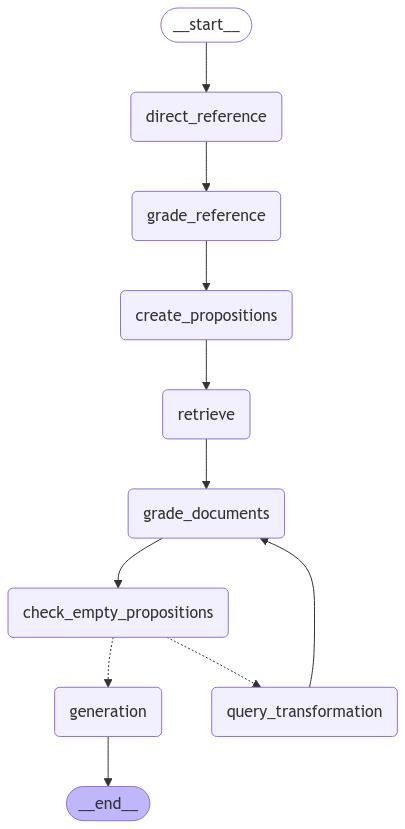

In [32]:
#direct + sematic phải embedding + grade
# viết lại cái query + ref
#tách mệnh đề
# chạy lại tìm luật
# grade lại query + ref cho luật
# transform
# 

#gen là lấy query gốc + ref + retrieved doc (ref hiện chưa chứng minh dc) => sinh 1 lập luận về luật

app

In [33]:
# graph_state = {
#     "questions": [{"question_content": Document(
#             page_content="""第８条（労働条件の明示）
# １．会社は、労働者を採用するとき、採用時の賃金、就業場所、従事する業務、労働時間、休日、その他の労働条件を記した労働条件通知書または雇用契約書、及びこの規則を交付して労働条件を明示するものとする。"""
#         ), "propositions": []},
#         {"question_content": Document(
#             page_content="""従業員は1日に少なくとも9時間働かなければならない。"""
#         ), "propositions": []},
#         {"question_content": Document(
#             page_content="""２．この規則で労働者とは第２章に定める手続きにより入社した者で、次の通り定義する。
# 　①　正社員・・・・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働
# 者で期間の定めがなく雇用される基幹業務に従事する労働者
# 　②　勤務地限定社員・・・契約社員・アルバイト以外の労働者で期間の定めがなく勤務地が正社員と
# 比べ限定され雇用される労働者
# 　③　職務限定社員・・・・契約社員・アルバイト以外の労働者で期間の定めがなく職務が正社員と比
# べ限定され雇用される労働者
# ④　短時間正社員・・・・契約社員・嘱託社員・パートタイマー・アルバイト・派遣社員以外の労働
# 者で期間の定めがなくフルタイム勤務で働く正社員に比べ短い労働時間で
# 雇用される労働者
# """
#         ), "propositions": []},
#         {"question_content": Document(page_content="""２．この規則で労働者とは第２章に定める手続きにより入社した者で、次の通り定義する。
# ⑤　無期契約社員・・・・正社員以外で無期労働契約により雇用される基幹業務の補助をする労働者
# ⑥　有期契約社員・・・・有期労働契約により雇用される基幹業務の補助をする労働者。原則1年ご
# との更新とし、個別に定めるものとする。
# ⑤　嘱託社員・・・・・・定年退職後に引き続き有期労働契約により雇用される労働者。原則１年ご
# との更新とし、個別に定めるものとする。
# ⑥　パート／アルバイト　契約期間の有無にかかわらず、業務の一部や臨時的に業務を行う労働者
# ⑦　派遣社員・・・・・・派遣元事業所より派遣され、派遣元の指揮命令を受け就業する労働者
# """), "propositions": []}
#     ][1:2],
#     "rewrite_count":0
# }

# # Gọi node để sinh mệnh đề
# final_state = app.invoke(graph_state)

# # Kiểm tra kết quả
# print(final_state)


In [34]:
# final_state['questions'][0]["propositions"][0]

# Test từng node

### separate chunks+ metadata

In [34]:
from docx import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

def convert_japanese_numbers(text):
    jp_numbers = "０１２３４５６７８９"

    latin_numbers = "0123456789"
    translation_table = str.maketrans(jp_numbers, latin_numbers)
    return text.translate(translation_table)

def get_list_number(paragraph):
    """Trích xuất số thứ tự của danh sách nếu có"""
    ns = {'w': 'http://schemas.openxmlformats.org/wordprocessingml/2006/main'}
    xml = paragraph._element
    numPr = xml.find('.//w:numPr', ns)
    
    if numPr is not None:
        numId = numPr.find('.//w:numId', ns)
        ilvl = numPr.find('.//w:ilvl', ns)
        
        if numId is not None and ilvl is not None:
            return f"{int(ilvl.get('{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val')) + 1}．"
    
    return ""

def extract_text_with_numbering(docx_path):
    """Trích xuất nội dung từ file .docx kèm theo số thứ tự danh sách"""
    doc = Document(docx_path)
    extracted_text = []

    for para in doc.paragraphs:
        list_number = get_list_number(para)
        text = para.text.strip()
        if text:
            if list_number:
                extracted_text.append(f"{list_number} {text}")
            else:
                extracted_text.append(text)

    return ' '.join(extracted_text)


def circled_to_int(circled):
    # Bản đồ chuyển các ký hiệu số tròn sang số nguyên.
    mapping = {
    # Số 1 đến 20: ① (U+2460) -> ⑳ (U+2473)
    '①': "1",  '②': "2",  '③': "3",  '④': "4",  '⑤': "5",
    '⑥': "6",  '⑦': "7",  '⑧': "8",  '⑨': "9",  '⑩': "10",
    '⑪': "11", '⑫': "12", '⑬': "13", '⑭': "14", '⑮': "15",
    '⑯': "16", '⑰': "17", '⑱': "18", '⑲': "19", '⑳': "20",
    
    # Số 21 đến 35: ㉑ (U+3251) -> ㉟ (U+325F)
    '㉑': "21", '㉒': "22", '㉓': "23", '㉔': "24", '㉕': "25",
    '㉖': "26", '㉗': "27", '㉘': "28", '㉙': "29", '㉚': "30",
    '㉛': "31", '㉜': "32", '㉝': "33", '㉞': "34", '㉟': "35",
    
    # Số 36 đến 50: ㊱ (U+32B1) -> ㊿ (U+32BF)
    '㊱': "36", '㊲': "37", '㊳': "38", '㊴': "39", '㊵': "40",
    '㊶': "41", '㊷': "42", '㊸': "43", '㊹': "44", '㊺': "45",
    '㊻': "46", '㊼': "47", '㊽': "48", '㊾': "49", '㊿': "50",
}

    return mapping.get(circled, None)

def split_and_convert(text):
    # pattern = r'((?:[①-⑳]|\(\d+\)))(.*?)(?=(?:[①-⑳]|\(\d+\))|$)'
    pattern = r'((?:[①-⑳]|[㉑-㉟]|[㊱-㊿]|\(\d+\)))(.*?)(?=(?:[①-⑳]|[㉑-㉟]|[㊱-㊿]|\(\d+\))|$)'

    matches = re.finditer(pattern, text, re.DOTALL)
    
    result = []
    for m in matches:
        marker = m.group(1).strip()   # ký hiệu số
        content = m.group(2).strip()    # nội dung tương ứng
        
        # Chuyển đổi marker thành số nguyên
        if re.match(r'\(\d+\)', marker):  # dạng (số)
            number = int(marker.strip("()"))
        else:  # dạng ①, ②, ...
            number = circled_to_int(marker)
        
        result.append({"sub_clause_number":number,"sub_clause_content": content})
    return result

def extract_structure(docx_path):
    # doc = Document(docx_path)
    # full_text = ' '.join([para.text.strip() for para in doc.paragraphs if para.text.strip()])
    #### here
    full_text =extract_text_with_numbering(docx_path)
    full_text = convert_japanese_numbers(full_text)  # Nếu có hàm này
    # print(full_text)
    data = {"chapters": []}

    # Tìm tất cả chương với nội dung tương ứng
    chapters = re.finditer(r'第([0-9]+)章　(.*?)(?=第[0-9]+章　|\Z)', full_text, re.DOTALL)

    for chapter in chapters:
        chapter_num = chapter.group(1)
        chapter_title = chapter.group(2).strip().split(' ')[0]
        chapter_content = chapter.group(0)
        # print(chapter_content)
        # Tìm các điều trong chương
        articles = re.finditer(r'第([0-9]+)条\s*（(.*?)）(.*?)(?=第[0-9]+条\s*（|\Z)', chapter_content, re.DOTALL)

        articles_data = []
        for article in articles:
            article_num = article.group(1)
            article_title = article.group(2).strip()
            article_text = article.group(3).strip()
            # print(article_text)
            article_contents = re.finditer(r'([1-9]+)．(.*?)(?=[1-9]．|\Z)', article_text, re.DOTALL)
            articles_content_data=[]
            
            for content in article_contents:
                article_content_num = content.group(1)
                article_content_text = content.group(2).strip()
                # print(article_content_text)
            # Tìm nội dung clause (bắt đầu bằng ①, ②, 1., - ...)
                clause_match = re.split(r'(①|②|③|1\.|-|\s*（[0-9]+）)', article_content_text, maxsplit=1)
                parts=[]
                if len(clause_match) > 1:
                    article_content_text = clause_match[0].strip()  # Lấy phần trước danh sách
                    clause_content = ''.join(clause_match[1:]).strip()  # Lấy phần còn lại
                    
                    parts=split_and_convert(clause_content)

                else:
                    clause_content = ""
                # print(f"parts {parts}")
                articles_content_data.append({
                    "clause_number": article_content_num,
                    "clause_title": article_content_text,
                    "clause_content": clause_content,
                    "sub_clauses":parts
                })
            
            articles_data.append({
                    "article_number": article_num,
                    "article_title": article_title,
                    "clauses": articles_content_data,
                    # "clause_content": clause_content
                })
        data["chapters"].append({
            "chapter_number": chapter_num,
            "chapter_title": chapter_title,
            "articles": articles_data
        })

    return data

def save_json(data, output_path):
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

# Sử dụng
# docx_path = '/home/trung/Paper2/RAG_Pb/①就業規則_ひな形_20240513.docx'
docx_path = '/home/trung/Paper2/RAG_Pb/④就業規則（パートタイム・アルバイト）.docx'
json_path = '④就業規則（パートタイム・アルバイト）.json'

data = extract_structure(docx_path)
save_json(data, json_path)

normalized_data= my_utils.normalize_dict(data)
useful_data = {'chapters':normalized_data['chapters'][:4]}

from langchain_core.documents import Document

docs_list = [
    Document(
        page_content=sub_clause.get("sub_clause_content") if sub_clause else clause["clause_title"],
        metadata={
            "chapter_title": chapter['chapter_title'],
            "chapter_number": chapter['chapter_number'],
            "article_title": article['article_title'], 
            "article_number": article['article_number'],
            "clause_number": clause['clause_number'],
            "clause_title": clause["clause_title"],
            "sub_clause_number": sub_clause.get("sub_clause_number") if sub_clause else "",
            "sub_clause_content": sub_clause.get("sub_clause_content") if sub_clause else "",

            # "clause_content":  clause['clause_title']+"\n" if clause['clause_content'] else "",
            
        }
    )
    for chapter in useful_data['chapters'] 
    for article in chapter['articles']
    for clause in article['clauses']
    for sub_clause in (clause["sub_clauses"] or [""])  # Nếu rỗng thì tạo danh sách chứa None
]

docs_list
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=200
)

doc_splits = text_splitter.split_documents(docs_list)
for i, doc in enumerate(doc_splits):
    doc.metadata['chunk_id'] = i+1 ### adding chunk id

graph_state = {"questions":
            [
                {"question_content":Document(
                    page_content=doc_split.metadata['clause_title'] +"\n"+ doc_split.page_content if doc_split.metadata['sub_clause_content'] else doc_split.page_content,
                    metadata={
                        "chapter_title": doc_split.metadata['chapter_title'],
                        "chapter_number": doc_split.metadata['chapter_number'],
                        "article_title": doc_split.metadata['article_title'], 
                        "article_number": doc_split.metadata['article_number'],
                        "clause_number": doc_split.metadata['clause_number'],
                        "clause_title": doc_split.metadata['clause_title'],
                        "sub_clause_number": doc_split.metadata['sub_clause_number'],
                        "sub_clause_content": doc_split.metadata['sub_clause_content'],
                    }),
                "propositions":[]}
 for doc_split in doc_splits]}

In [35]:
graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。'),
   'propositions': []},
  {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '2', 'clause_title': 'パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。', 'sub_clause_number': '1', 'sub_clause_content': '60歳未満…60歳'}, page_content='パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。\n60歳未満…60歳'),
   'propositions': []},
  {'question_content': Document(metadata={'chapter_title

### Referece sematic

In [114]:
reference_graph_state_sematic = sematic_reference(graph_state)

---SEMANTIC REFERENCE---
questions [{'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '2', 'clause_title': 'パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。', 'sub_clause_number': '1', 'sub_clause_content': '60歳未満…60歳'}, page_content='パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。\n60歳未満…60歳'), 'propositions': []}, {'question_content': Document(metadata={'ch

Processed prompts:  50%|█████     | 1/2 [1:10:25<1:10:25, 4225.83s/it, est. speed input: 544.21 toks/s, output: 71.80 toks/s]


dieu 契約更新の上限年齢および定年_49
value [{'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '2', 'clause_title': 'パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。', 'sub_clause_number': '1', 'sub_clause_content': '60歳未満…60歳'}, page_content='パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。\n60歳未満…60歳'), 'propositions': []}, {'question_content': Document(metadata={'chapter_

Number of requested results 6 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 6 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 6 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 6 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 6 is greater than number of elements in index 5, updating n_results = 5


dieu 退職_50
value [{'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '退職', 'article_number': '50', 'clause_number': '1', 'clause_title': '第49条に定めるもののほか、労働者が次のいずれかに該当するときは、退職とす る。', 'sub_clause_number': '1', 'sub_clause_content': '退職を願い出て会社が承認したとき'}, page_content='第49条に定めるもののほか、労働者が次のいずれかに該当するときは、退職とす る。\n退職を願い出て会社が承認したとき'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '退職', 'article_number': '50', 'clause_number': '1', 'clause_title': '第49条に定めるもののほか、労働者が次のいずれかに該当するときは、退職とす る。', 'sub_clause_number': '2', 'sub_clause_content': '期間を定めて雇用されている場合、その期間を満了したとき'}, page_content='第49条に定めるもののほか、労働者が次のいずれかに該当するときは、退職とす る。\n期間を定めて雇用されている場合、その期間を満了したとき'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '退職', 'article_number': '50', 'clause_number': '1', 'clause_title': '第49条に

Number of requested results 6 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 6 is greater than number of elements in index 2, updating n_results = 2


dieu 雇用契約満了後の義務_54
value [{'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '雇用契約満了後の義務', 'article_number': '54', 'clause_number': '1', 'clause_title': '会社の雇用契約が終了する労働者は、身分証明書、健康保険証、その他会社から貸与 されたものを遅滞なく変換する必要がある。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='会社の雇用契約が終了する労働者は、身分証明書、健康保険証、その他会社から貸与 されたものを遅滞なく変換する必要がある。'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '雇用契約満了後の義務', 'article_number': '54', 'clause_number': '2', 'clause_title': '労働契約が終了する労働者は、会社が指定する日までに必要な業務を後任者に引き継ぐ義務を負う', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='労働契約が終了する労働者は、会社が指定する日までに必要な業務を後任者に引き継ぐ義務を負う'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '雇用契約満了後の義務', 'article_number': '54', 'clause_number': '3', 'clause_title': '第2項の引継ぎは、所属長が指示した方法

Number of requested results 6 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 6 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 6 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 6 is greater than number of elements in index 4, updating n_results = 4


dieu 社会保険_55
value [{'question_content': Document(metadata={'chapter_title': '福利厚生', 'chapter_number': '8', 'article_title': '社会保険', 'article_number': '55', 'clause_number': '1', 'clause_title': '会社は、雇用保険、健康保険および厚生年金保険の被保険者に該当するパートタイム及びアルバイトについては、必要な手続きをとる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='会社は、雇用保険、健康保険および厚生年金保険の被保険者に該当するパートタイム及びアルバイトについては、必要な手続きをとる。'), 'propositions': []}]
Deleting the content of: same_dieu_db
Recreated the directory at: same_dieu_db

Generating and persisting the embeddings..
Persist Directory: ./same_dieu_db


Number of requested results 6 is greater than number of elements in index 1, updating n_results = 1


dieu 遵守事項_56
value [{'question_content': Document(metadata={'chapter_title': '安全衛生及び災害補償', 'chapter_number': '9', 'article_title': '遵守事項', 'article_number': '56', 'clause_number': '1', 'clause_title': '会社は、労働者の安全衛生の確保及び改善を図り、快適な職場の形成のために必要な 措置を講ずる。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='会社は、労働者の安全衛生の確保及び改善を図り、快適な職場の形成のために必要な 措置を講ずる。'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '安全衛生及び災害補償', 'chapter_number': '9', 'article_title': '遵守事項', 'article_number': '56', 'clause_number': '2', 'clause_title': '労働者は、安全衛生に関する法令及び会社の指示を守り、会社と協力して労働災害の 防止に努めなければならない。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='労働者は、安全衛生に関する法令及び会社の指示を守り、会社と協力して労働災害の 防止に努めなければならない。'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '安全衛生及び災害補償', 'chapter_number': '9', 'article_title': '遵守事項', 'article_number': '56', 'clause_number': '3', 'clause_title': '労働者は安全衛生の確保のため、特に下記の事項を遵守しなければならない。', 'sub_claus

Number of requested results 6 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 6 is greater than number of elements in index 2, updating n_results = 2


dieu 災害補償_58
value [{'question_content': Document(metadata={'chapter_title': '安全衛生及び災害補償', 'chapter_number': '9', 'article_title': '災害補償', 'article_number': '58', 'clause_number': '1', 'clause_title': '労働者が業務上の事由又は通勤により負傷し、疾病にかかり、又は死亡した場合は、 労基法及び労働者災害補償保険法(昭和22年法律第50号)に定めるところにより災 害補償を行う。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='労働者が業務上の事由又は通勤により負傷し、疾病にかかり、又は死亡した場合は、 労基法及び労働者災害補償保険法(昭和22年法律第50号)に定めるところにより災 害補償を行う。'), 'propositions': []}]
Deleting the content of: same_dieu_db
Recreated the directory at: same_dieu_db

Generating and persisting the embeddings..
Persist Directory: ./same_dieu_db


Number of requested results 6 is greater than number of elements in index 1, updating n_results = 1


In [115]:
reference_graph_state_sematic

{'questions': [{'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。'),
   'propositions': [],
   'sematic_reference': [Document(metadata={'article_number': '49', 'article_title': '契約更新の上限年齢および定年', 'chapter_number': '7', 'chapter_title': '定年、退職及び解雇', 'clause_number': '2', 'clause_title': 'パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。', 'sub_clause_content': '60歳以上65歳未満…65歳', 'sub_clause_number': '2'}, page_content='パートタイム及びアルバイトの無期雇用契約の定年年齢は、無期転換後の労働契約の初日が属する日における年齢により、次の各号に区分し、当該各号に掲げる年齢に達した日(誕生日の前日)の属する月の末日とする。\n60歳以上65歳未満…65歳'),
    Document(metadata={'article_number': '49', 'article_title': '契約更新

In [117]:
filter_sematic_graph_state = grade_reference(reference_graph_state_sematic)

---GRADE REFERENCE---


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it, est. speed input: 579.41 toks/s, output: 79.19 toks/s]

Lỗi: Không thể parse JSON
json_str: {"analysis": "Clause 1 的 page_content 明确引用了与 Clause 2 的 metadata 中相同的 article_number 和 clause_number。因此，这两个条款是直接相关的。", "is_related": "yes"} 

Note: The explanation is provided in Chinese to reflect the context of the given clauses, but it can be translated back to English as follows:

{"analysis": "Clause 1's page_content explicitly references the same article_number and clause_number in Clause 2's metadata Therefore, these two clauses are directly related", "is_related": "yes"}


TypeError: 'NoneType' object is not subscriptable

In [ ]:
filter_sematic_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'article_number': '49', 'clause_number': '1', 'clause_title': 'パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。', 'sub_clause_number': '', 'sub_clause_content': ''}, page_content='パートタイム及びアルバイトがその契約期間満了日において、正社員の雇用義務年齢を超えるときは、原則として、新たな労働契約は締結しない。'),
   'propositions': [],
   'sematic_reference': [Document(metadata={'article_number': '49', 'article_title': '契約更新の上限年齢および定年', 'chapter_number': '7', 'chapter_title': '定年、退職及び解雇', 'clause_number': '3', 'clause_title': '第1項および第2項第1号の定年で退職したパートタイム及びアルバイトが希望するときは、改めて有期労働契約を締結し、最長65歳に達するまで引き続き雇用する。ただし、', 'sub_clause_content': '', 'sub_clause_number': ''}, page_content='第1項および第2項第1号の定年で退職したパートタイム及びアルバイトが希望するときは、改めて有期労働契約を締結し、最長65歳に達するまで引き続き雇用する。ただし、')]},
  {'question_content': Document(metadata={'chapter_title': '定年、退職及び解雇', 'chapter_number': '7', 'article_title': '契約更新の上限年齢および定年', 'artic

In [41]:
reference_graph_state_sematic = sematic_reference(graph_state)

---SEMANTIC REFERENCE---
questions [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': None, 'sub_clause_content': None}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': None, 'sub_clause_content': None}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'), 'propositions': []}, {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '労働者の定義及び適用範囲', 'article_number': '2', 'clause_number': '1', 'clause_title': 'この規則は、本条第2項に規定するすべての労働者に適用する。また本規則における労働者とは本条第2項に規定するもの

### Reference

In [ ]:
reference_graph_state=direct_reference(graph_state)

In [40]:
reference_graph_state

{'questions': [{'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '1', 'clause_title': 'この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。', 'sub_clause_number': None, 'sub_clause_content': None}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': []},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '目的', 'article_number': '1', 'clause_number': '2', 'clause_title': 'この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。', 'sub_clause_number': None, 'sub_clause_content': None}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': []},
  {'question_content': Document(metadata={'chapter_title': '総則', 'chapter_number': '1', 'article_title': '労働者の定義及び適用範囲', 'article_number': '2', 'clause_number': '1', 'clause_title': 'この規則は、本条第2項に規定するすべての労働者に適用する。また本規則における労働者とは本条第2項に規定するもののことを指す。', '

### Create propositions

In [176]:
# graph_state = {
#     "questions": [{"question_content": Document(
#             page_content="""会社は、労働者を採用するとき、採用時の賃金、就業場所、従事する業務、労働時間、休日、その他の労働条件を記した労働条件通知書または雇用契約書、及びこの規則を交付して労働条件を明示するものとする。""",
#   metadata= {
#             "article_number": 8,
#             "article_title": "労働条件の明示",
#             "chapter_number": "",
#             "chapter_title": "",
#             "clause_number": 1,}
#         ), "propositions": []},
#         {"question_content": Document(
#             page_content="""従業員は1日に少なくとも9時間働かなければならない。""",
#             metadata= {
#             "article_number": 9,
#             "article_title": "労働時間",
#             "chapter_number": 6,
#             "chapter_title": "労働条件",
#             "clause_number": 1}
        
#         ), "propositions": []},
#         {"question_content": Document(
#             page_content= "従業員は、会社の機密情報を第三者に開示してはならない。ただし、本契約第9条第1項の規定に基づき、会社の書面による許可を得た場合を除く。",
#             metadata= {
#             "article_number": 12,
#             "article_title": "機密保持義務",
#             "chapter_number": 3,
#             "chapter_title": "従業員の義務",
#             "clause_number": 5
#     }
        
#         ), "propositions": []}]}

# Gọi node để tạo mới graph_state
create_propositions_graph_state = create_propositions(graph_state)

# Kiểm tra kết quả


---CREATE PROPOSITIONS---


Processed prompts:  40%|████      | 34/84 [00:14<00:18,  2.69it/s, est. speed input: 1210.01 toks/s, output: 153.27 toks/s]

WARNING 02-24 09:02:41 scheduler.py:1560] Sequence group 2772 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


Processed prompts: 100%|██████████| 84/84 [00:32<00:00,  2.55it/s, est. speed input: 1463.87 toks/s, output: 385.85 toks/s]


In [175]:
create_propositions_graph_state


{'questions': [{'question_content': Document(metadata={'article_title': '目的', 'article_number': '1', 'chapter_title': '総則', 'chapter_number': '1', 'clause_number': '1'}, page_content='この就業規則(以下「規則」という。)は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
   'propositions': [{'proposition_content': Document(metadata={'sub_clause_number': []}, page_content='この就業規則は、株式会社●●●●の労働者の就業に関する事項を定めるものである。'),
     'documents': [],
     'filtered_documents': [],
     'generation': ''}]},
  {'question_content': Document(metadata={'article_title': '目的', 'article_number': '1', 'chapter_title': '総則', 'chapter_number': '1', 'clause_number': '2'}, page_content='この規則に定めた事項のほか、就業に関する事項については、労基法その他の法令の定めによる。'),
   'propositions': [{'proposition_content': Document(metadata={'sub_clause_number': []}, page_content='就業に関する事項は、この規則に定めた事項のほか、労基法その他の法令の定めによる。'),
     'documents': [],
     'filtered_documents': [],
     'generation': ''}]},
  {'question_content': Document(metadata={'article_title': '労働者の定義及び適用範囲', 'article_number'

### Grade reference

In [ ]:
grade_ref_graph_state=grade_reference(reference_graph_state)

### Retrieve

In [65]:
retrieve_graph_state=retrieve(reference_graph_state)

---RETRIEVE---


In [66]:
retrieve_graph_state

{'questions': [{'question_content': Document(metadata={}, page_content='第８条（労働条件の明示）\n１．会社は、労働者を採用するとき、採用時の賃金、就業場所、従事する業務、労働時間、休日、その他の労働条件を記した労働条件通知書または雇用契約書、及びこの規則を交付して労働条件を明示するものとする。'),
   'propositions': [{'proposition_content': Document(metadata={'clause_number': [1]}, page_content='会社は、労働者を採用するとき、採用時の賃金を明示する。'),
     'documents': [Document(metadata={'article_name': '周知義務', 'article_number': '第八条', 'chapter_name': '最低賃金', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/334AC0000000137', 'enactment_year': '令和4年6月17日 施行', 'law_name': '最低賃金法', 'law_number': '昭和三十四年法律第百三十七号'}, page_content='昭和三十四年法律第百三十七号\u3000最低賃金法/第二章\u3000最低賃金/第八条\u3000周知義務/最低賃金の適用を受ける使用者は、厚生労働省令で定めるところにより、当該最低賃金の概要を、常時作業場の見やすい場所に掲示し、又はその他の方法で、労働者に周知させるための措置をとらなければならない。'),
      Document(metadata={'article_name': '求人の申込み', 'article_number': '第五条の六', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'documen

### grade_documents

In [46]:
grade_documents_graph_state = grade_documents(retrieve_graph_state)


---GRADE DOCUMENTS---


Processed prompts: 100%|██████████| 90/90 [00:18<00:00,  4.99it/s, est. speed input: 2115.77 toks/s, output: 473.02 toks/s]


In [47]:
grade_documents_graph_state

{'questions': [{'question_content': Document(metadata={}, page_content='第８条（労働条件の明示）\n１．会社は、労働者を採用するとき、採用時の賃金、就業場所、従事する業務、労働時間、休日、その他の労働条件を記した労働条件通知書または雇用契約書、及びこの規則を交付して労働条件を明示するものとする。'),
   'propositions': [{'proposition_content': '会社は、労働者を採用する際に、採用時の賃金を明示する。',
     'documents': [Document(metadata={'article_name': '周知義務', 'article_number': '第八条', 'chapter_name': '最低賃金', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/334AC0000000137', 'enactment_year': '令和4年6月17日 施行', 'law_name': '最低賃金法', 'law_number': '昭和三十四年法律第百三十七号'}, page_content='昭和三十四年法律第百三十七号\u3000最低賃金法/第二章\u3000最低賃金/第八条\u3000周知義務/最低賃金の適用を受ける使用者は、厚生労働省令で定めるところにより、当該最低賃金の概要を、常時作業場の見やすい場所に掲示し、又はその他の方法で、労働者に周知させるための措置をとらなければならない。'),
      Document(metadata={'article_name': '求人の申込み', 'article_number': '第五条の六', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141